# Mountain Car Miniproject: Marija Zelic and Nicolas Moyne

This notebook is here to guide you through the basics of the frameworks necessary for you to do well on your CS456-Miniproject 🤓

In [188]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.style as style
from matplotlib.colors import Normalize
import math
from tqdm import tqdm

## Gymnasium environments

One of the main and most spread environment developer in the field of RL research is [Gymnasium](https://gymnasium.farama.org/). They provide standardized environments offering a large range of difficulties and setups, that are perfectly designed to benchmark performances of RL and Deep RL algorithms.

The main structure is very simple to understand. First, we need to instantiate our environment. We will use an existing environment, but one could also use their structure to design their own environment.

Let's directly work with the Mountain Car environment that will be used in the project. 

_PS: If you're more curious, feel free to browse the large list available on their website!_

In [53]:
env = gym.make('MountainCar-v0')

In [54]:
# Use the 'ggplot' style
style.use('ggplot')

In [55]:
lista = [[1, 2], [3, 4], [5, 6]]
stacked = np.vstack(lista)
print(stacked)
mean = np.mean(stacked, axis=0)
print(mean)
print(stacked-mean)

[[1 2]
 [3 4]
 [5 6]]
[3. 4.]
[[-2. -2.]
 [ 0.  0.]
 [ 2.  2.]]


The environment contains an action space and an observation (state) space. Let's see what these look like.

In [56]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [57]:
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")
print(f"Observation shape: {env.observation_space.low}")
print(f"Observation shape: {env.observation_space.high}")
current_velocity = np.array([0.3, 0.2])
current_velocity = np.interp(current_velocity, np.array([0, 1]), np.array([-0.5, 0.5]))
print(current_velocity)

Number of actions available: 3
Observation shape: (2,)
Observation shape: [-1.2  -0.07]
Observation shape: [0.6  0.07]
[-0.2 -0.3]


As we can see, the action space of that first environment is discrete and contains 3 possible actions: accelerate to the left, don't accelerate and accelerate to the right. 

The observation space has a dimension of 2, and you can find what each part represents [here](https://gymnasium.farama.org/environments/classic_control/mountain_car/#observation-space).

Before taking actions, the environment should be reset (or boostrapped). **Note: this should be done every time the environment has to be restarted, i.e., at the end of any episode.**

In [58]:
# the second return value is an info dictionary, but it doesn't contain anything in this environment
starting_state, _ = env.reset() 

print(f"Starting state: {starting_state}")

Starting state: [-0.40990412  0.        ]


Now that we know what the actions look like and that the environment is ready, we can take actions inside it. This is done using the `env.step` function, that takes an action as input, and returns multiple values. More details on each of them can be found [here](https://gymnasium.farama.org/api/env/#gymnasium.Env.step).

In the project, you will have an agent that will choose an action (based on the policy learned) given the current state. However, for now, we can simply sample actions at random using `action_space.sample()`.

In [59]:
action = env.action_space.sample()
print(f"Sampled action: {action}")
next_state, reward, terminated, truncated, _ = env.step(action) # again, the last return value is an empty info object

print(f"Next state: {next_state}")
print(f"Reward: {reward}")
print(f"Terminated: {terminated}")
print(f"Truncated: {truncated}")

Sampled action: 1
Next state: [-0.4107404  -0.00083627]
Reward: -1.0
Terminated: False
Truncated: False


The `terminated` and `truncated`  variables represent the two ways that the episode might be done. Thus, it might be handy to use
```
done = terminated or truncated
```
in your code. 💡

We now have all the pieces necessary to run a full episode!

In [60]:
done = False
state, _ = env.reset()
episode_reward = 0

while not done:
    action = env.action_space.sample()
    next_state, reward, terimnated, truncated, _ = env.step(action)

    episode_reward += reward

    state = next_state
    done = terminated or truncated

print(f"Episode reward after taking random actions: {episode_reward}")

Episode reward after taking random actions: -200.0


Episode reward after taking deterministic sense of movement action: -123.0


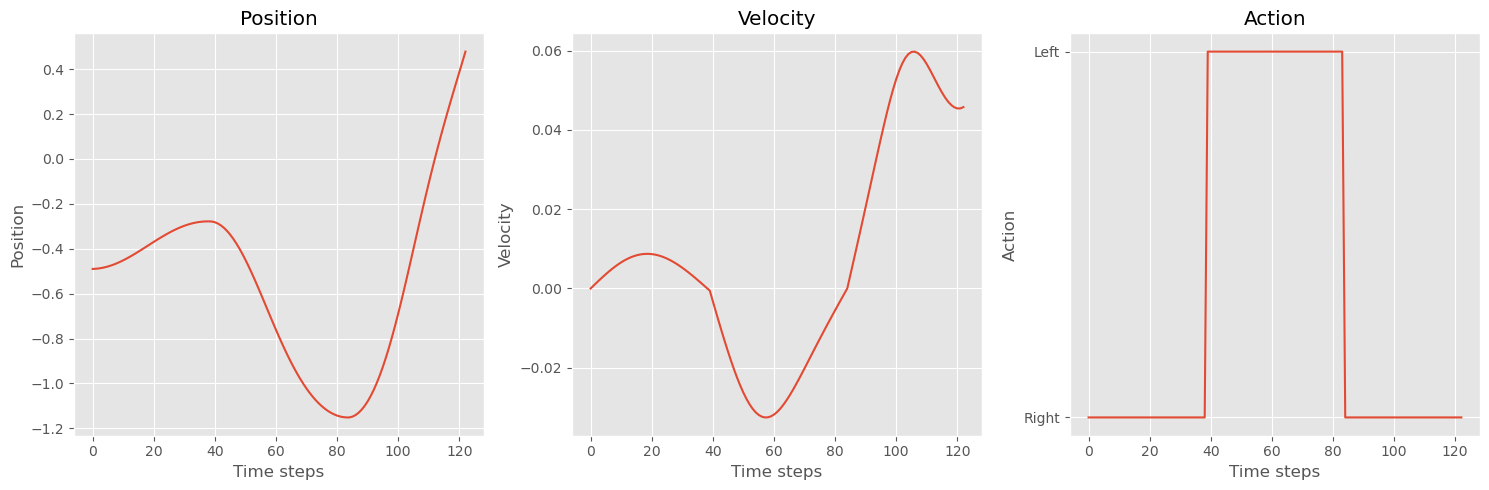

In [61]:
# Initialize lists to store episode data
positions = []
velocities = []
actions = []

done = False
state, _ = env.reset()
episode_reward = 0

while not done:
    action = 0 if state[1] < 0 else 2
    next_state, reward, terminated, truncated, _ = env.step(action)

    # Store data for visualization
    positions.append(state[0])
    velocities.append(state[1])
    actions.append(action)

    episode_reward += reward

    state = next_state
    done = terminated or truncated

print(f"Episode reward after taking deterministic sense of movement action: {episode_reward}")

# Plotting
plt.figure(figsize=(15, 5))

# Position plot
plt.subplot(1, 3, 1)
plt.plot(positions)
plt.title('Position')
plt.xlabel('Time steps')
plt.ylabel('Position')

# Velocity plot
plt.subplot(1, 3, 2)
plt.plot(velocities)
plt.title('Velocity')
plt.xlabel('Time steps')
plt.ylabel('Velocity')

# Action plot
plt.subplot(1, 3, 3)
actions_labels = ['Left', 'Nothing', 'Right']
action_labels = [actions_labels[action] for action in actions]
plt.plot(action_labels)
plt.title('Action')
plt.xlabel('Time steps')
plt.ylabel('Action')

plt.tight_layout()
plt.show()


In [62]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.episode = []

    def observe(self, state, action, next_state, reward):
        # Store the transition tuple (state, action, next_state, reward)
        self.episode.append([state, action, next_state, reward])

    def select_action(self, state):
        # This function picks an action from the given state randomly.
        return self.env.action_space.sample()

    def update(self):
        # This function is called after each environment step. 
        # Since this agent doesn't learn, there's no update to perform.
        pass
    def reset(self, env):
        # This function is called at the end of each episode.
        # It should reset the agent's internal state.
        self.episode = []
        self.env = env

[-0.56773967, -0.56606954, -0.5640817, -0.56179106, -0.55821455, -0.5533789, -0.5483202, -0.5440762, -0.5386788, -0.5341683, -0.5285786, -0.52195144, -0.5143367, -0.5067914, -0.49837214, -0.4911419, -0.48415464, -0.47646257, -0.46812284, -0.45919725, -0.45175168, -0.44384077, -0.43552238, -0.4268569, -0.41890687, -0.41172916, -0.4043748, -0.39889568, -0.39333016, -0.389717, -0.38608116, -0.3824477, -0.3798415, -0.3792804, -0.37976813, -0.38230148, -0.38686308, -0.3924217, -0.39793894, -0.40537646, -0.41468218, -0.4247903, -0.4366287, -0.44811198, -0.4611566, -0.4756668, -0.49053526, -0.5066513, -0.5228943, -0.5381427, -0.553282, -0.567199, -0.5817899, -0.5959466, -0.6095649, -0.62254566, -0.6357951, -0.64821887, -0.6597296, -0.67124754, -0.68269396, -0.692992, -0.70107347, -0.70688593, -0.711392, -0.7155629, -0.71837234, -0.7188027, -0.7188513, -0.71751785, -0.71481067, -0.7107467, -0.7043518, -0.6956666, -0.6847476, -0.67366636, -0.66249734, -0.64931643, -0.63521487, -0.6202917, -0.60

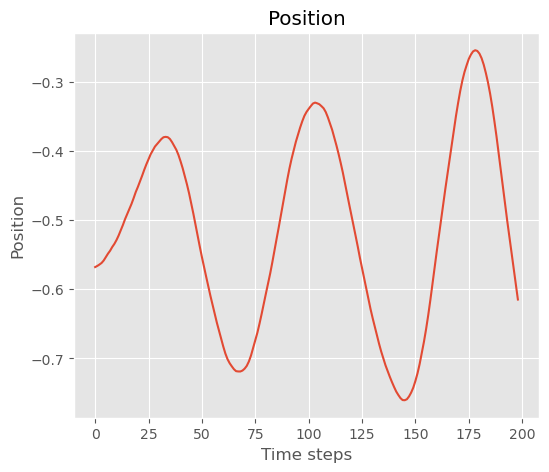

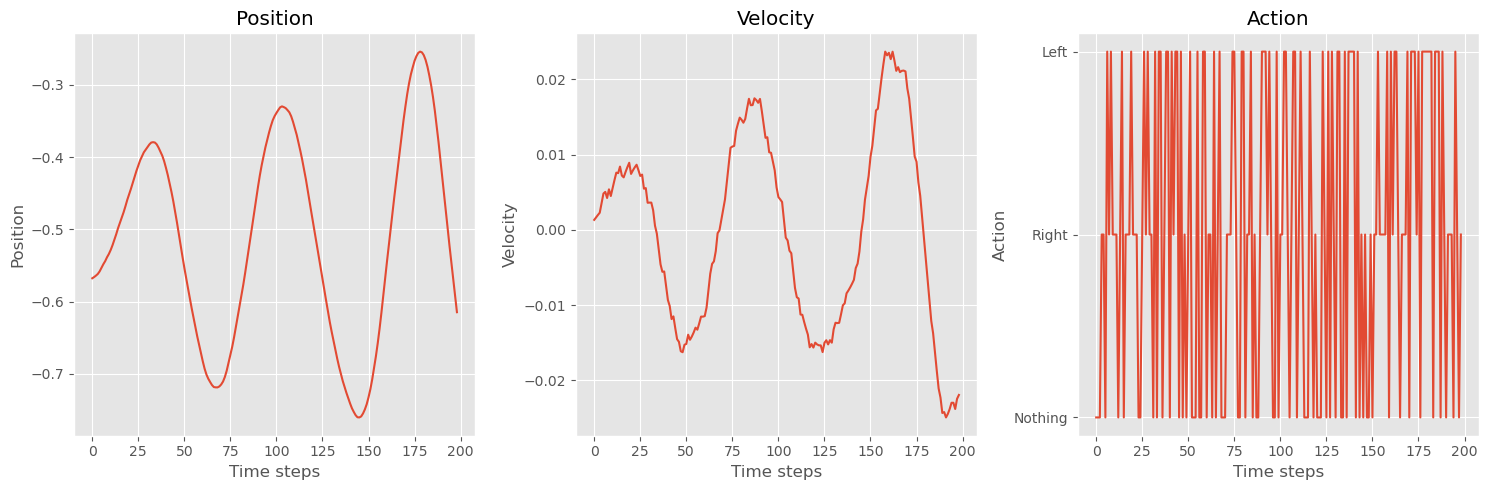

In [64]:
# Create agent
agent = RandomAgent(env)

# Reset environment
state = env.reset()

# Run the agent until the episode is truncated or terminated
done = False
while not done:
    action = agent.select_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    agent.observe(state, action, next_state, reward)
    state = next_state

# Visualize the episode
positions = [s[0][0] for s in agent.episode][1:]
velocities = [s[0][1] for s in agent.episode][1:]
actions = [s[1] for s in agent.episode][1:]

plt.figure(figsize=(6,5))
plt.plot(positions)
plt.title('Position')
plt.xlabel('Time steps')
plt.ylabel('Position')

plt.figure(figsize=(15, 5))

print(positions)
print(velocities)
print(actions)

# Position plot
plt.subplot(1, 3, 1)
plt.plot(positions)
plt.title('Position')
plt.xlabel('Time steps')
plt.ylabel('Position')

# Velocity plot
plt.subplot(1, 3, 2)
plt.plot(velocities)
plt.title('Velocity')
plt.xlabel('Time steps')
plt.ylabel('Velocity')

# Action plot
plt.subplot(1, 3, 3)
actions_labels = ['Left', 'Nothing', 'Right']
action_labels = [actions_labels[action] for action in actions]
plt.plot(action_labels)
plt.title('Action')
plt.xlabel('Time steps')
plt.ylabel('Action')

plt.tight_layout()
plt.show()

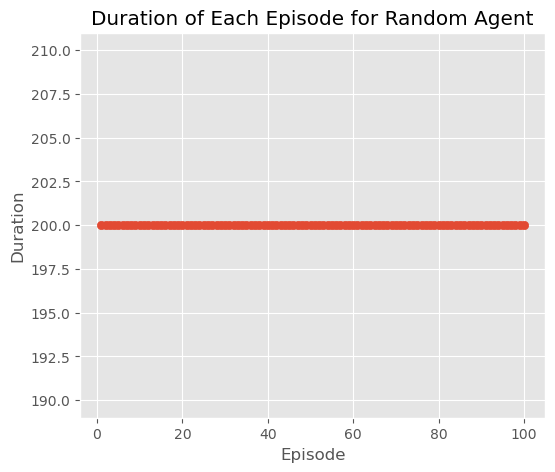

In [67]:
# Create agent
agent = RandomAgent(env)

# Run agent for 100 episodes
episode_durations = []
for episode in range(100):
    # Initialize environment with a new randomly sampled seed
    state = env.reset()
    agent.reset(env)
    episode_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.observe(state, action, next_state, reward)
        state = next_state
        episode_reward += reward
    episode_durations.append(len(agent.episode))

# Plot episode durations as a scatter plot
plt.figure(figsize=(6, 5))
plt.scatter(range(1, 101), episode_durations)
plt.title('Duration of Each Episode for Random Agent')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.grid(True)
plt.show()

In [12]:
class NotRandomAgent:
    def __init__(self, env):
        self.env = env
        self.episode = []

    def observe(self, state, action, next_state, reward):
        # Store the transition tuple (state, action, next_state, reward)
        self.episode.append([state, action, next_state, reward])

    def select_action(self, state):
        # This function picks an action from the given state randomly.
        action = 0 if state[1] < 0 else 2
        return action

    def update(self):
        # This function is called after each environment step. 
        # Since this agent doesn't learn, there's no update to perform.
        pass
    def reset(self, env):
        # This function is called at the end of each episode.
        # It should reset the agent's internal state.
        self.episode = []
        self.env = env

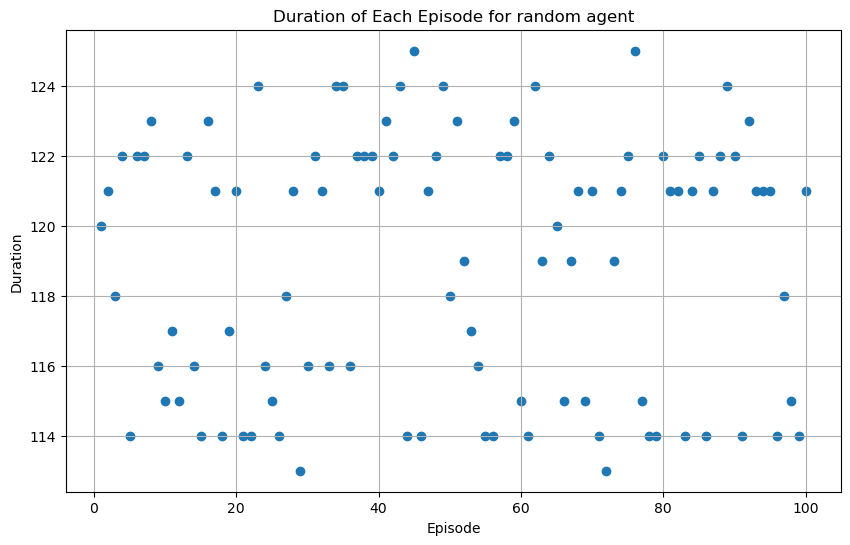

In [13]:
# Create agent
agent = NotRandomAgent(env)

# Run agent for 100 episodes
episode_durations = []
for episode in range(100):
    # Initialize environment with a new randomly sampled seed
    state = env.reset()[0]
    agent.reset(env)
    episode_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, truncated, terminated, _ = env.step(action)
        done = terminated or truncated
        agent.observe(state, action, next_state, reward)
        state = next_state
        episode_reward += reward
    episode_durations.append(len(agent.episode))

# Plot episode durations as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(1, 101), episode_durations)
plt.title('Duration of Each Episode for random agent')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.grid(True)
plt.show()

## DQN

In [155]:
# Define a class for replay buffer
class ReplyBuffer:
    def __init__(self, capacity = 10000):
        """ Data structure to store previous episodes for training. """
        self.capacity = capacity
        
        self.states = deque(maxlen=capacity)
        self.actions = deque(maxlen=capacity)
        self.next_states = deque(maxlen=capacity)
        self.rewards = deque(maxlen=capacity)
        self.terminated = deque(maxlen=capacity)
        self.truncated = deque(maxlen=capacity)
        
    def add(self, state, action, next_state, reward, terminated, truncated):
        """ Append observed state, action, next_state, reward, terminated and truncated to their respective deques. """
        
        self.states.append(state)
        self.actions.append(action)
        self.next_states.append(next_state)
        self.rewards.append(reward)
        self.terminated.append(terminated)
        self.truncated.append(truncated)
        
    def sample_batch(self, batch_size):
        """ Sample randomly observed states, actions, next_states, rewards, terminated and truncated from their respective deques
            in sized specified by batch_size. Turn it to tensors. """
        
        indices = np.random.choice(self.len(), size=batch_size, replace=False)
        states = torch.stack([torch.as_tensor(self.states[i], dtype=torch.float32) for i in indices])
        actions = torch.as_tensor([self.actions[i] for i in indices], dtype=torch.long)
        next_states = torch.stack([torch.as_tensor(self.next_states[i], dtype=torch.float32) for i in indices])
        rewards = torch.as_tensor([self.rewards[i] for i in indices], dtype=torch.float32)
        terminated = torch.as_tensor([self.terminated[i] for i in indices], dtype=torch.bool)
        truncated = torch.as_tensor([self.truncated[i] for i in indices], dtype=torch.bool)
        
        return states, actions, next_states, rewards, terminated, truncated
    
    def len(self):
        """ To check how many samples is stored in the memory. """
        return len(self.terminated)        

In [157]:
# Define the class for making a feed-forward network
class networkDQN(nn.Module):
    """ DeepQ Network for RL, consisting of FC layers with adjustable dimensions of layers and ReLU activation function. """
    def __init__(self, input_dim, output_dim, layer_dims):
        """ 
        Initialize DQN network.
        
        Parameters:
            input_dim (int): The dimensionality of the input state space. 
            output_dim (int): The number of possible actions in the environment (in this case 3).
            layers_dims (list of int): Size of hidden layers. 
        """
        super(networkDQN, self).__init__()
        # Initialize sequential for storing the layers in the network 
        self.FC = nn.Sequential()
        self.FC.append(nn.Linear(input_dim, layer_dims[0]))
        self.FC.append(nn.ReLU(inplace=True)) 
        # Add layers
        for i in range(len(layer_dims)):
            if i==(len(layer_dims)-1):
                self.FC.append(nn.Linear(layer_dims[i], output_dim))
            else:
                self.FC.append(nn.Linear(layer_dims[i], layer_dims[i+1]))
                self.FC.append(nn.ReLU(inplace=True))
            
    def forward(self, input):
        """ 
        Feed-forward network to estimate Q-values for pair of current input state and each action. 
        
        Parameters:
            input (torch.tensor): Input tensor representing the state.
        
        Return:
            Q (torch.tensor): Output tensor containing Q-values for current input state. 
        """
        Q = self.FC(input)
        return Q              

In [161]:
# Now we implement the class DQNAgent
class DQNAgent:
    """ Class that uses feed-forward network to estimate Q-values and an epsilon-greedy policy to take actions. """
    
    def __init__(self, env, epsilon_factor=0.997, layer_dims=[64, 64], seed=42, discount_factor=0.99, epsilon_max=0.9, epsilon_min=0.05, learning_rate=0.001, capacity=10000):
        
        # Loss record
        self.loss_record = []
        self.loss_episode = 0
        self.steps = 0
        
        # RL hyperparameters
        self.discount_factor = discount_factor
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_factor = epsilon_factor
        
        self.action_space = env.action_space
        self.action_space.seed(seed) 
        self.observation_space = env.observation_space
        self.replay_buffer = ReplyBuffer(capacity)
        
        # Initialize the network model
        input_dim = self.observation_space.shape[0]
        output_dim = self.action_space.n # number of available actions
        
        self.neural_network = networkDQN(input_dim=input_dim, output_dim=output_dim, layer_dims=layer_dims)
        self.target_network = networkDQN(input_dim=input_dim, output_dim=output_dim, layer_dims=layer_dims).eval()
        self.target_network.load_state_dict(self.neural_network.state_dict()) # set target to the main neural network
        
        # Loss function and optimizer
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.AdamW(self.neural_network.parameters(), lr=learning_rate)
        
    def epsilon_greedy(self, state):
        """
        Implements epsilon-greedy policy that combines exploration and exploitation. 
        If some random values is less than epsilon, we choose random action. If it is not then we select the one for which we have largest Q-value. 
        
        Parameters:
            state (torch.tensor): Tensor representing the state.
        
        Returns:
            action(int) : Represents the action that should be taken.
        """
        
        # Take random action if random value is less than epsilon_max
        if np.random.random() < self.epsilon_max:
            return self.action_space.sample()
        
        # If not, take the action with largest Q-value
        if not torch.is_tensor(state):
            state = torch.as_tensor(state, dtype=torch.float32)
        
        # Run the neural network to obtain Q-values for current state
        with torch.no_grad():
            Q_values = self.neural_network(state)
            action = torch.argmax(Q_values).item()
            
        return action
    
    def train_agent(self, done, batch_size=64):
        """ 
        Method for training the agent. 
        
        Parameters:
            done (bool): Indicates whether episode is done or not. 
            batch_size (int): Specifies number of samples to take from replay buffer to do the update. 
        """       
        
        # Sample a batch from replay buffer
        states, actions, next_states, rewards, terminated, truncated = self.replay_buffer.sample_batch(batch_size)
        
        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        terminated = terminated.unsqueeze(1)   
        truncated = truncated.unsqueeze(1)
        
        # Pass the batch through the neural network to find the Q-values for the speicific states
        # If batch_size is 64, the dimension of the would be 64x3 (so for each state in the batch and the possible action that can be taken)
        q_values = self.neural_network(states)
        q_values = q_values.gather(dim=1, index=actions) # take Q-values of the actions that were taken in the specific states;
        # in the gradient update formula this is what is after minus sign
        
        # take the values on which max_action Q_target network is performed
        with torch.no_grad():
            next_state_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0]
        
        # set q-value of terminal state to 0
        next_state_q_value[terminated] = 0   
        target_q_values = rewards + self.discount_factor * next_state_q_value
        loss = self.loss_fn(q_values, target_q_values)
            
        # update loss
        self.loss_episode += loss.item()
        self.steps += 1
        
        if done:
            average_loss_episode = self.loss_episode / self.steps
            self.loss_record.append(average_loss_episode)
            
            # Reset
            self.loss_episode = 0
            self.steps = 0
        
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(self.neural_network.parameters(), 10)
        self.optimizer.step()
        
        
    def assign_target(self):
        """ Copies values of the parameters of the main network directly to the target network. """
        
        self.target_network.load_state_dict(self.neural_network.state_dict())
        
    def scheduler_epsilon_greedy(self):
        """ 
        Schedules decay of the epsilon parameter in the epsilon greedy policy. 
        In the begining there is higher epsilon and therefore higher chance for explorative behaviour. After time it becomes more exploitative.
        """
        self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_factor)        

### DQN - basic implementation (no heuristic for the reward)

In [80]:
# Additional class for Training and Testing for the model without the heuristic for the sparse reward
class modelNoHeuristic():
    """ Class that implements training and testing methods for the model without heuristic for the sparse reward function. """
    
    def __init__(self, env, epsilon_factor=0.997, layer_dims=[64, 64], seed=42, discount_factor=0.99, epsilon_max=0.9, epsilon_min=0.05, learning_rate=0.001, capacity=10000, batch_size=64, update_frequency=20, episodes_train=1000, episodes_test=500):

        self.env = env
        self.agent = DQNAgent(env=env, epsilon_factor=epsilon_factor, layer_dims=layer_dims, seed=seed, discount_factor=discount_factor, epsilon_max=epsilon_max, epsilon_min=epsilon_min, learning_rate=learning_rate, capacity=capacity)
        self.batch_size = batch_size
        # parameter that tells how often should the parameters of the target network should be updated with the parameters of the main network
        self.update_frequency = update_frequency 
        # number of epsiodes to run agent for (training)
        self.episodes_train = episodes_train
        # number of episodes to run agent for (testing)
        self.episodes_test = episodes_test
        self.seed = seed
        
    def train(self):
        """
        Training loop for DQN agent.
        """
        number_steps = 0 
        self.reward_record = [] # this will store average rewards per epsiode
        
        # Run agent self.episodes_train epsiodes
        for i in range(self.episodes_train):
            
            state = self.env.reset()[0]
            done = False 
            episode_reward = 0 # accumulates reward in the single episode
            episode_length = 0 # counts the lenght of the episode
            
            while not done:
                
                # Select action from the state according to the policy
                action = self.agent.epsilon_greedy(state)
                
                # Observe next_state, reward, terminated and truncated
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                
                # Store observed in the replay buffer
                self.agent.replay_buffer.add(state, action, next_state, reward, terminated, truncated)
                done = terminated or truncated
                
                # Just for debugging
                if terminated: # this means that the agent found the goal
                    print("goal found")
                
                # If there is more than self.batch_size in the replay buffer we can do the update
                if self.agent.replay_buffer.len() > self.batch_size:
                    
                    self.agent.train_agent(done=done, batch_size=self.batch_size) # Perform update
                    
                    # Total number of steps is multipy of self.update_frequency update parameters of the target network
                    if number_steps % self.update_frequency == 0:
                        
                        self.agent.assign_target()
                     
                # Updates
                state = next_state
                episode_reward += reward
                episode_length += 1
            
            print(f"Episode number: {i}")   
            # For recording
            average_cumulative = episode_reward / episode_length # we need to report average cumulative reward per episode
            self.reward_record.append(average_cumulative)
            number_steps += episode_length
            
            # Call epsilon (in epsilon-greedy) scheduler
            self.agent.scheduler_epsilon_greedy()
            
        # Plot results - loss and average cumulative reward per episode
        self.plot_results(mode="train")
        
    def plot_results(self, mode):
        """ Plot loss and average cumulative reward per episode. """
        
        if mode == "train":
            plt.figure(figsize=(12, 4))
            # (Average) Loss per episode
            plt.subplot(1, 2, 1)
            plt.plot(self.agent.loss_record)
            plt.title('Avg. loss per episode DQN - No aux. reward')
            plt.xlabel('Episode')
            plt.ylabel('Average loss')
            plt.grid(visible=True)

            # Average cumulative reward per episode
            plt.subplot(1, 2, 2)
            plt.plot(self.reward_record)
            plt.title('Avg. cum. reward per episode DQN - No aux. reward')
            plt.xlabel('Episode')
            plt.ylabel('Average cumulative reward')
            plt.grid(visible=True)
        
        if mode == "test":
            plt.figure(figsize=(6, 4))
            plt.plot(self.reward_record)
            plt.title('Average cumulative reward per episode')
            plt.xlabel('Episode')
            plt.ylabel('Average cumulative reward')
            plt.grid(visible=True)
        
    def test(self):
        """" Test RL model after training. """ 
        
        # Set agent into eval mode - no further training
        self.agent.neural_network.eval()
        
        self.reward_record = []
        
        # Test loop
        for i in range(self.episodes_test):
            
            state = self.env.reset()[0]
            done = False
            episode_reward = 0
            episode_length = 0
            
            while not done:
                
                # Select action from state according to the policy
                action = self.agent.epsilon_greedy(state)
                
                # Observe next_state, reward, terminated and truncated
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated 
                
                # For reporting purposes
                if terminated:
                    print("goal found")
                    
                # Update
                state = next_state
                episode_reward += reward
                episode_length += 1
            
            print(f"Episode number: {i}")
            average_cumulative = episode_reward / episode_length
            self.reward_record.append(average_cumulative)
        
        self.plot_results(mode="test")          

Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
Episode number: 36
Episode number: 37
Episode number: 38
Episode number: 39
Episode number: 40
Episode number: 41
Episode number: 42
Episode number: 43
Episode number: 44
Episode number: 45
Episode number: 46
Episode number: 47
Episode number: 48
Episode number: 49
Episode number: 50
Episode number: 51
Episode number: 52
Epi

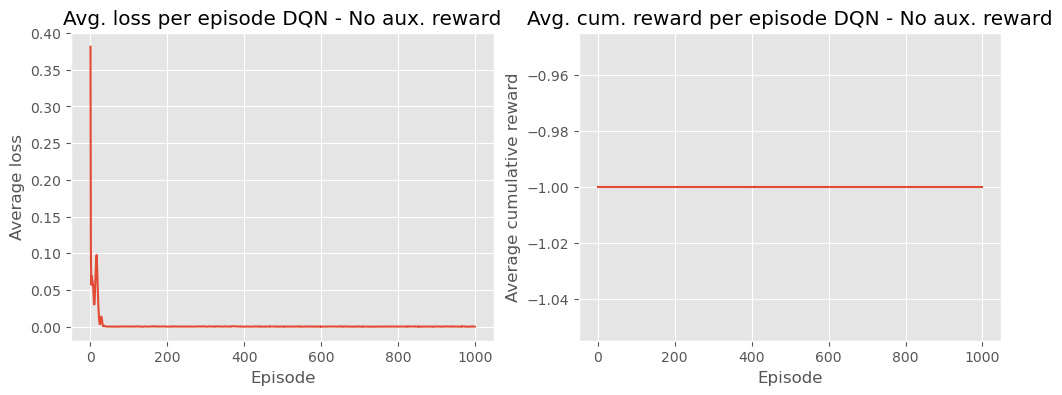

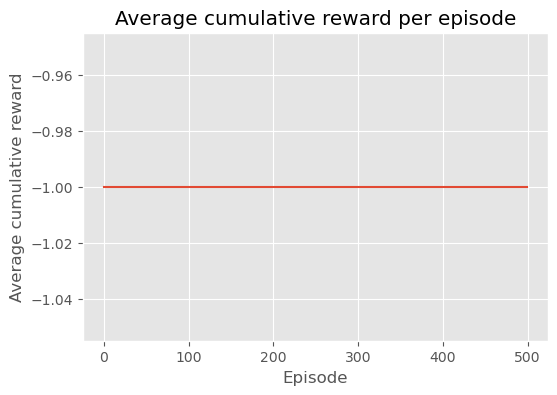

In [81]:
# Train and test the model with no heuristic for the reward 
model = modelNoHeuristic(env=env)
# train the model
model.train()
# test the model
model.test()

As we can see from the plots average cumulative reward per episode is -1 and we never see the agent achieve the goal (end of the episode is always due to truncation after 200 steps). The cause for this mainly relies on the sparsity of the reward accumulated over the steps towards the goal. We can try to improve this by reward reshaping, i.e. changing the reward in such way that agent gets the sense of the environment.  

### DQN - heuristic reward  

We reshape the reward according to the suggestions found in the paper, https://people.eecs.berkeley.edu/~pabbeel/cs287-fa09/readings/NgHaradaRussell-shaping-ICML1999.pdf, about potential-based shaping function. We take 2 options for the new function:  

* reward = reward + np.abs(position at the current state - starting position)
* reward = reward + 1000 * (0.99 * np.abs(position at the next state - starting position) - np.abs(position at the current state - starting position))  
* Reward as in case 1, with additional rewards received when the agent is close to the top of the hill, meaning when the positions are above 0.2 it gets additional reward. 

Logic for choosing the starting position value is the following: if is starting state always uniformly choosen from range $[-0.6, -0.4]$, mean value is $-0.5$ and therefore, that is starting position. We reward the agent when it moves a lot from starting position.  

Observations:
* When the reward is too small (case 1), agent manages to find the goal during the training, but fails in testing phase (I have run it for 1000 episodes, not 3000 as they suggested, which might be reason, but still not what is supposed to be achieved with the best heuristic).
* When the reward is larger (case 3), agent manages to find the goal during testing as well. 

In [201]:
# Additional class for Training and Testing for the model with the heuristic for the sparse reward
class modelWithHeuristic():
    """ Class that implements training and testing methods for the model with heuristic for the sparse reward function. """
    
    def __init__(self, env, epsilon_factor=0.997, layer_dims=[64, 64], seed=42, discount_factor=0.99, epsilon_max=0.9, epsilon_min=0.05, learning_rate=0.001, capacity=10000, batch_size=64, update_frequency=20, episodes_train=1000, episodes_test=1000, reward_heuristic=0):

        self.env = env
        self.agent = DQNAgent(env=env, epsilon_factor=epsilon_factor, layer_dims=layer_dims, seed=seed, discount_factor=discount_factor, epsilon_max=epsilon_max, epsilon_min=epsilon_min, learning_rate=learning_rate, capacity=capacity)
        self.batch_size = batch_size
        # parameter that tells how often should the parameters of the target network should be updated with the parameters of the main network
        self.update_frequency = update_frequency 
        # number of epsiodes to run agent for (training)
        self.episodes_train = episodes_train
        # number of episodes to run agent for (testing)
        self.episodes_test = episodes_test
        self.seed = seed
        # option for reward heuristic: 0 (first choice)/ 1 (second choice)
        self.reward_heuristic = reward_heuristic
        
    def train(self):
        """
        Training loop for DQN agent.
        """
        number_steps = 0 
        self.reward_record = [] # this will store average rewards per epsiode
        self.environment_reward_record = [] # this will store the rewards received from environment per episode
        self.auxiliary_reward_record = [] # this will store the auxiliary rewards received per epsisode
        self.number_of_successes = [] # for plotting cumulative number of successes
        self.episode_length_record = [] # stores duration of each episode for scatter plot 
        
        # Run agent self.episodes_train epsiodes
        for i in range(self.episodes_train):
            
            state = self.env.reset()[0]
            done = False 
            episode_reward = 0 # accumulates reward in the single episode
            episode_length = 0 # counts the lenght of the episode
            environment_reward = 0 # sums total reward from environment
            auxiliary_reward_total = 0 # sums total auxiliary reward
            terminated_found = 0 # indicates weather it's terminated or truncated for plotting
            
            while not done:
                
                # Set auxiliary_reward to 0 and terminated_found
                auxiliary_reward = 0
        
                # Select action from the state according to the policy
                action = self.agent.epsilon_greedy(state)
                
                # Observe next_state, reward, terminated and truncated
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                environment_reward += reward
                
                # Reward reshaping for the heuristic
                if self.reward_heuristic == 0:
                    auxiliary_reward += 5*np.abs(next_state[0] + 0.5) 
                    reward = reward + 5*np.abs(next_state[0] + 0.5)
                    
                    # Additional stimuly if it is close to goal
                    if next_state[0] >= 0.5:
                        reward += 150
                        auxiliary_reward += 100
                    elif next_state[0] >= 0.3:
                        reward += 50
                        auxiliary_reward += 100
                    elif next_state[0] >= 0.1:
                        reward += 25
                        auxiliary_reward += 50
                    
                    auxiliary_reward_total += auxiliary_reward
                      
                if self.reward_heuristic == 1:
                    auxiliary_reward += (next_state[0] + 1.2) / 1.8 
                    reward += (next_state[0] + 1.2) / 1.8 
                    auxiliary_reward_total += auxiliary_reward
                    
                if self.reward_heuristic == 2:
                    auxiliary_reward = 100*((math.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1])) 
                    auxiliary_reward_total += auxiliary_reward
                    reward =  auxiliary_reward
                    
                # Store observed in the replay buffer
                self.agent.replay_buffer.add(state, action, next_state, reward, terminated, truncated)
                done = terminated or truncated
                
                # Just for debugging
                if terminated: # this means that the agent found the goal
                    print("goal found")
                    terminated_found = 1
                
                # If there is more than self.batch_size in the replay buffer we can do the update
                if self.agent.replay_buffer.len() > self.batch_size:
                    
                    self.agent.train_agent(done=done, batch_size=self.batch_size) # Perform update
                    
                    # Total number of steps is multipy of self.update_frequency update parameters of the target network
                    if number_steps % self.update_frequency == 0:
                        
                        self.agent.assign_target()
                     
                # Updates
                state = next_state
                episode_reward += reward
                episode_length += 1
            
            print(f"Episode number: {i}")   
            # For recording
            self.reward_record.append(episode_reward)
            self.environment_reward_record.append(environment_reward)
            self.auxiliary_reward_record.append(auxiliary_reward_total)
            self.number_of_successes.append(terminated_found)
            self.episode_length_record.append(episode_length)
            number_steps += episode_length
            
            # Call epsilon (in epsilon-greedy) scheduler
            self.agent.scheduler_epsilon_greedy()
            
        # Plot results
        self.plot_results(mode="train")
        
    def plot_results(self, mode):
        """ Plot metrics to discuss results. """
        
        # Scatter plot of the duration of the episode 
        if mode == "train":
            length = self.episodes_train
        else:
            length = self.episodes_test
            
        plt.figure(figsize=(6, 5))
        plt.scatter(range(1,length+1), self.episode_length_record, s=20)
        plt.title('Duration of each episode for agent with heuristic reward function')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.grid(visible = True)
        
        # Accumulated reward per episode smoothed with averaging window, environment, auxiliary
        smoothed_reward_record = np.convolve(self.reward_record, np.ones(50)/50, mode='valid')
        smoothed_environment_reward_record = np.convolve(self.environment_reward_record, np.ones(50)/50, mode='valid')
        smoothed_auxiliary_reward_record = np.convolve(self.auxiliary_reward_record, np.ones(50)/50, mode='valid')
        
        # Cumulative reward over episodes (reward accumulated up to the an episode n), environment, auxiliary
        cumulative_reward = np.cumsum(self.reward_record)
        cumulative_environment_reward = np.cumsum(self.environment_reward_record)
        cumulative_auxiliary_reward = np.cumsum(self.auxiliary_reward_record)
        
        plt.figure(figsize=(6, 5))
        # Accumulated reward plots
        plt.plot(smoothed_reward_record, label="Total reward")
        plt.plot(smoothed_environment_reward_record, label="Environment reward")
        plt.plot(smoothed_auxiliary_reward_record, label="Auxiliary reward")
        plt.xlabel('Episode')
        plt.ylabel('Accumulated smoothed reward')
        plt.title('Smoothed accumulated reward per episode')
        plt.legend()
        plt.grid(visible=True)
        
        plt.figure(figsize=(6, 5))
        # Cumulative reward plots
        plt.plot(cumulative_reward, label="Total reward")
        plt.plot(cumulative_environment_reward, label="Environment reward")
        plt.plot(cumulative_auxiliary_reward, label="Auxiliary reward")
        plt.title('Cumulative reward over episodes')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative reward')
        plt.legend()
        plt.grid(visible=True)
        
        # Plotting cumulative number of successes
        cumulative_n_successes = np.cumsum(self.number_of_successes)
        plt.figure(figsize=(6, 4))
        plt.plot(cumulative_n_successes)
        plt.title('Cumulative number of successes')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative successes')
        plt.grid(visible=True)
        
        if mode == "train":
            plt.figure(figsize=(6, 5))
            plt.plot(self.agent.loss_record)
            plt.title('Average loss per episode')
            plt.xlabel('Episode')
            plt.ylabel('Average loss')
            plt.grid(visible=True)
        
    def test(self, seeds):
        """" Test RL model after training. """ 
        
        # Set agent into eval mode - no further training
        self.agent.neural_network.eval()
        
        self.agent.epsilon_max = 0
        self.reward_record = []
        self.episode_length_record = []
        self.environment_reward_record = []
        self.auxiliary_reward_record = []
        self.number_of_successes = []
        
        # Test loop
        for i in range(self.episodes_test):
            
            state = self.env.reset(seed=seeds[i].item())[0]
            done = False
            episode_reward = 0
            episode_length = 0
            auxiliary_reward_total = 0
            environment_reward = 0
            terminated_found = 0
            
            while not done:
                
                # Set auxiliary_reward to 0
                auxiliary_reward = 0 
                
                # Select action from state according to the policy
                action = self.agent.epsilon_greedy(state)
                
                # Observe next_state, reward, terminated and truncated
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                environment_reward += reward
                
                # Reward reshaping for the heuristic
                if self.reward_heuristic == 0:
                    auxiliary_reward += 5*np.abs(next_state[0] + 0.5)
                    
                    # Additional stimuly if it is close to goal
                    if next_state[0] >= 0.5:
                        auxiliary_reward += 150
                    elif next_state[0] >= 0.3:
                        auxiliary_reward += 100
                    elif next_state[0] >= 0.1:
                        auxiliary_reward += 50
                    
                    auxiliary_reward_total += auxiliary_reward
                    reward = reward + auxiliary_reward
                      
                if self.reward_heuristic == 1:
                    auxiliary_reward += (next_state[0] + 1.2) / 1.8 
                    reward += (next_state[0] + 1.2) / 1.8 
                    auxiliary_reward_total += auxiliary_reward
                    
                if self.reward_heuristic == 2:
                    auxiliary_reward = 100*((-math.cos(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (-math.cos(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1])) 
                     
                done = terminated or truncated 
                
                # For reporting purposes
                if terminated:
                    print("goal found")
                    terminated_found = 1
                    
                # Update
                state = next_state
                episode_reward += reward
                episode_length += 1
            
            print(f"Episode number: {i}")
            self.reward_record.append(episode_reward)
            self.environment_reward_record.append(environment_reward)
            self.auxiliary_reward_record.append(auxiliary_reward_total)
            self.episode_length_record.append(episode_length)
            self.number_of_successes.append(terminated_found)
        
        # Plot results 
        self.plot_results(mode="test")          

Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
Episode number: 36
Episode number: 37
Episode number: 38
Episode number: 39
Episode number: 40
Episode number: 41
Episode number: 42
Episode number: 43
Episode number: 44
Episode number: 45
Episode number: 46
Episode number: 47
Episode number: 48
Episode number: 49
Episode number: 50
Episode number: 51
Episode number: 52
Epi

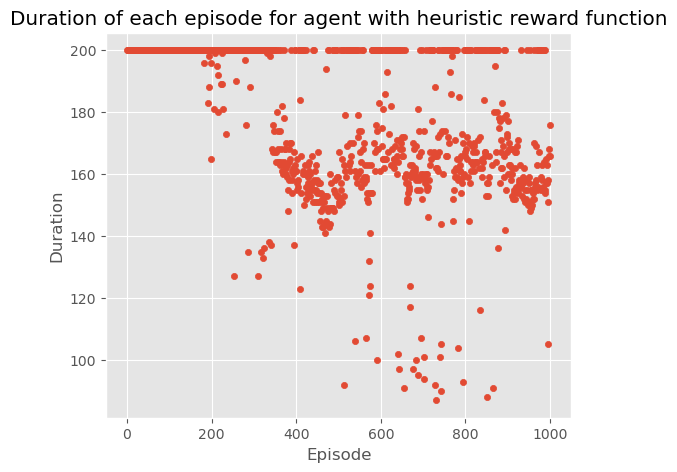

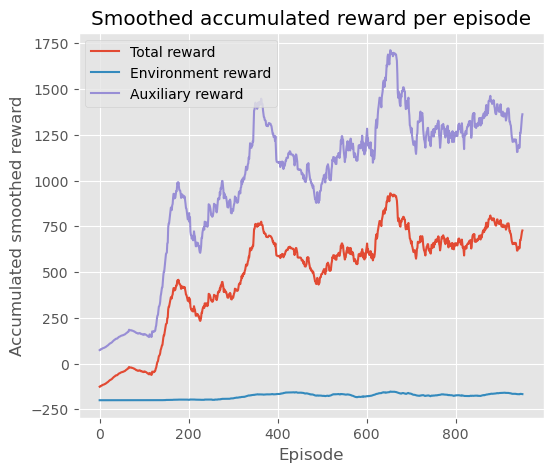

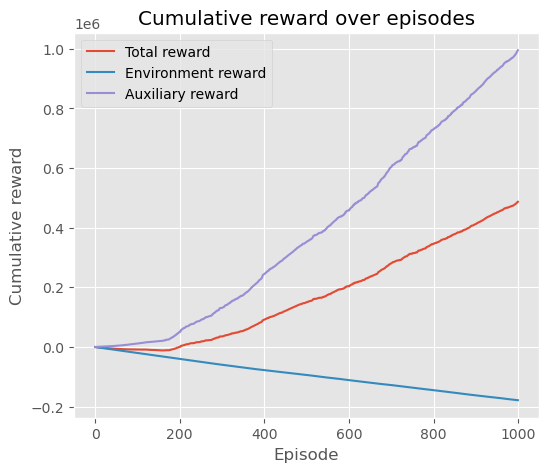

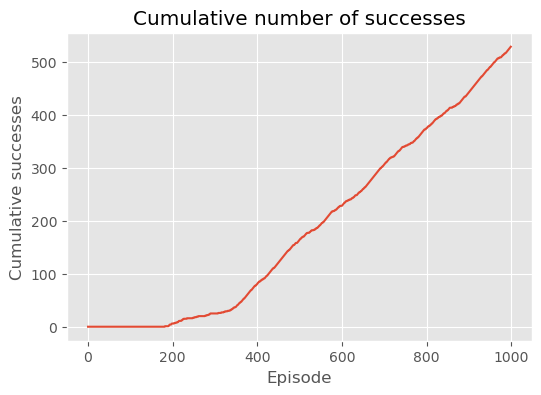

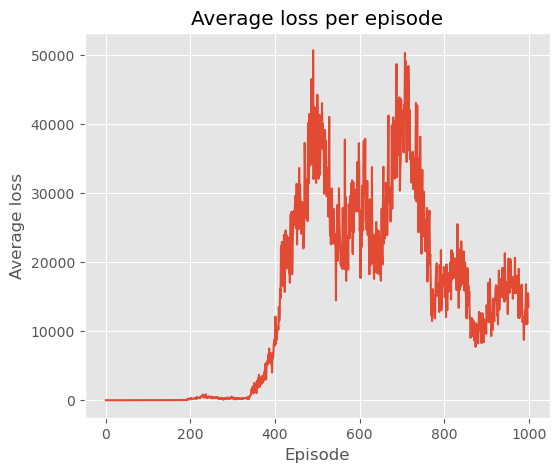

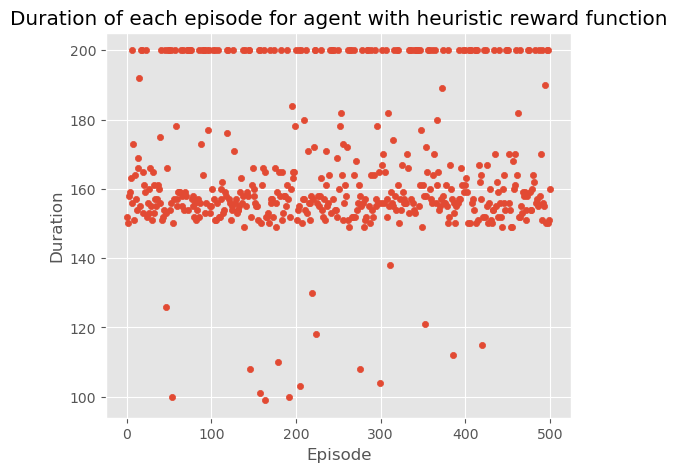

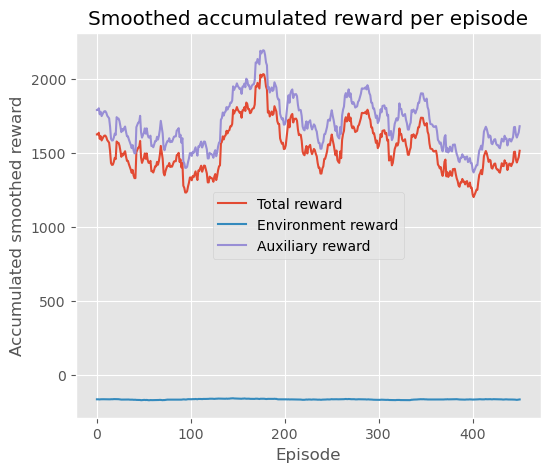

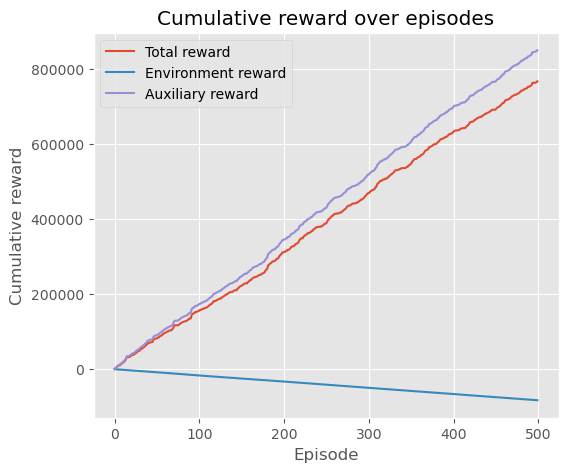

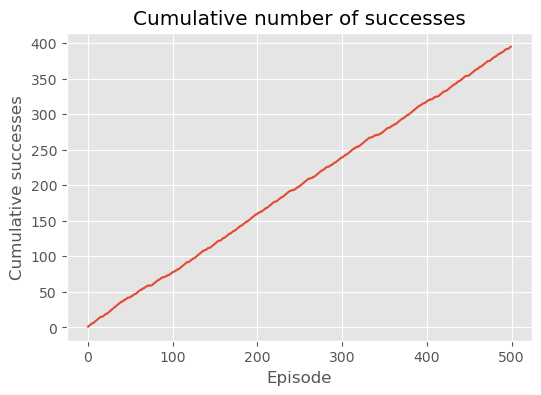

In [163]:
# Train and test the model with no heuristic for the reward 
model_heuristic = modelWithHeuristic(env=env)
# train the model
model_heuristic.train()
# test the model
model_heuristic.test()

## DQN with Random Network Distillation

In [180]:
# Define the class for RND object
class RND:
    """ Implements Random Network Distillation. """
    def __init__(self, input_dim, output_dim, layer_dims, learning_rate):
        
        # target network RND
        self.target_network_rnd = networkDQN(input_dim=input_dim, output_dim=output_dim, layer_dims=layer_dims).eval()
        
        # predictor network RND
        self.predictor_network_rnd = networkDQN(input_dim=input_dim, output_dim=output_dim, layer_dims=layer_dims)
        self.optimizer = optim.AdamW(self.predictor_network_rnd.parameters(), lr=learning_rate)
        
    def compute_RND_intrinsic_reward(self, next_state):
        """ 
        Computes RND intrinsic reward given the next_state (next_state is already normalized).
        Intrinsic RND reward is calculated as the squared difference between the output of the predictor and the target network applied 
        to the next_state, with some normalization. """
        
        target_output = self.target_network_rnd(next_state).detach()
        predictor_output = self.predictor_network_rnd(next_state)
        RND_reward = torch.pow(predictor_output-target_output, 2).sum()
        
        return RND_reward   
    
    def update_function(self, reward):
        """
        Gradient update on reward, i.e. sqared difference between output of predictor network and target network.
        """  
        self.optimizer.zero_grad()   
        reward.backward()
        self.optimizer.step()
        

In [181]:
# Implement new class for DQN agent that includes RND
class DQNAgentWithRND:
    """ 
    Class that uses feed-forward network to estimate Q-values and an epsilon-greedy policy to take actions and
    RND approach for reward rehsaping. 
    """
    
    def __init__(self, env, epsilon_factor=0.997, layer_dims_dqn=[64, 64], layer_dims_rnd=[64, 64], seed=42, discount_factor=0.99, epsilon_max=0.9, epsilon_min=0.05, learning_rate=0.001, capacity=10000):
        
        # Loss record
        self.loss_record = []
        self.loss_episode = 0
        self.steps = 0
        
        # RL hyperparameters
        self.discount_factor = discount_factor
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        self.epsilon_factor = epsilon_factor
        
        self.action_space = env.action_space
        self.action_space.seed(seed) 
        self.observation_space = env.observation_space
        self.replay_buffer = ReplyBuffer(capacity)
        
        # Initialize the DQN network model
        input_dim_dqn = self.observation_space.shape[0]
        output_dim_dqn = self.action_space.n # number of available actions
        
        self.neural_network = networkDQN(input_dim=input_dim_dqn, output_dim=output_dim_dqn, layer_dims=layer_dims_dqn)
        self.target_network = networkDQN(input_dim=input_dim_dqn, output_dim=output_dim_dqn, layer_dims=layer_dims_dqn).eval()
        self.target_network.load_state_dict(self.neural_network.state_dict()) # set target to the main neural network
        
        # Loss function and optimizer
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.AdamW(self.neural_network.parameters(), lr=learning_rate)
        
        # Initialize RND object
        input_dim_rnd = self.observation_space.shape[0]
        output_dim_rnd = 1
        
        self.rnd = RND(input_dim=input_dim_rnd, output_dim=output_dim_rnd, layer_dims=layer_dims_rnd, learning_rate=learning_rate)
        
    def epsilon_greedy(self, state):
        """
        Implements epsilon-greedy policy that combines exploration and exploitation. 
        If some random values is less than epsilon, we choose random action. If it is not then we select the one for which we have largest Q-value. 
        
        Parameters:
            state (torch.tensor): Tensor representing the state.
        
        Returns:
            action(int) : Represents the action that should be taken.
        """
        
        # Take random action if random value is less than epsilon_max
        if np.random.random() < self.epsilon_max:
            return self.action_space.sample()
        
        # If not, take the action with largest Q-value
        if not torch.is_tensor(state):
            state = torch.as_tensor(state, dtype=torch.float32)
        
        # Run the neural network to obtain Q-values for current state
        with torch.no_grad():
            Q_values = self.neural_network(state)
            action = torch.argmax(Q_values).item()
            
        return action
    
    def train_agent(self, done, batch_size=64):
        """ 
        Method for training the agent. 
        
        Parameters:
            done (bool): Indicates whether episode is done or not. 
            batch_size (int): Specifies number of samples to take from replay buffer to do the update. 
        """       
        
        # Sample a batch from replay buffer
        states, actions, next_states, rewards, terminated, truncated = self.replay_buffer.sample_batch(batch_size)
        
        actions = actions.unsqueeze(1)
        rewards = rewards.unsqueeze(1)
        terminated = terminated.unsqueeze(1)   
        truncated = truncated.unsqueeze(1)
        
        # Intrinsic reward updates
        intrinsic_reward = self.rnd.compute_RND_intrinsic_reward(next_states)
        self.rnd.update_function(intrinsic_reward)
        
        # Pass the batch through the neural network to find the Q-values for the speicific states
        # If batch_size is 64, the dimension of the would be 64x3 (so for each state in the batch and the possible action that can be taken)
        q_values = self.neural_network(states)
        q_values = q_values.gather(dim=1, index=actions) # take Q-values of the actions that were taken in the specific states;
        # in the gradient update formula this is what is after minus sign
        
        # take the values on which max_action Q_target network is performed
        with torch.no_grad():
            next_state_q_value = self.target_network(next_states).max(dim=1, keepdim=True)[0]
        
        # set q-value of terminal state to 0
        next_state_q_value[terminated] = 0   
        target_q_values = rewards + self.discount_factor * next_state_q_value
        loss = self.loss_fn(q_values, target_q_values)
            
        # update loss
        self.loss_episode += loss.item()
        self.steps += 1
        
        if done:
            average_loss_episode = self.loss_episode / self.steps
            self.loss_record.append(average_loss_episode)
            
            # Reset
            self.loss_episode = 0
            self.steps = 0
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def assign_target(self):
        """ Copies values of the parameters of the main network directly to the target network. """
        
        self.target_network.load_state_dict(self.neural_network.state_dict())
        
    def scheduler_epsilon_greedy(self):
        """ 
        Schedules decay of the epsilon parameter in the epsilon greedy policy. 
        In the begining there is higher epsilon and therefore higher chance for explorative behaviour. After time it becomes more exploitative.
        """
        self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_factor)        

In [204]:
# Additional class for Training and Testing for the model with RND as intrisic reward
class modelWithRND():
    """ Class that implements training and testing methods for the model with heuristic for the sparse reward function. """
    
    def __init__(self, env, epsilon_factor=0.997, layer_dims_dqn=[64, 64], layer_dims_rnd=[64, 64], seed=42, discount_factor=0.99, epsilon_max=0.9, epsilon_min=0.05, reward_factor = 100, learning_rate=0.001, capacity=10000, batch_size=64, update_frequency=20, episodes_train=400, episodes_test=1000):

        self.env = env
        self.agent = DQNAgentWithRND(env=env, epsilon_factor=epsilon_factor, layer_dims_dqn=layer_dims_dqn, layer_dims_rnd=layer_dims_rnd, seed=seed, discount_factor=discount_factor, epsilon_max=epsilon_max, epsilon_min=epsilon_min, learning_rate=learning_rate, capacity=capacity)
        self.batch_size = batch_size
        # parameter that tells how often should the parameters of the target network should be updated with the parameters of the main network
        self.update_frequency = update_frequency 
        # number of epsiodes to run agent for (training)
        self.episodes_train = episodes_train
        # number of episodes to run agent for (testing)
        self.episodes_test = episodes_test
        self.seed = seed
        # stores next states for normalization parameters update
        self.store_next_states = []
        # stores intrinsic rewards for normalization parameters update
        self.store_intrinsic_rewards = []
        # reward factor
        self.reward_factor = reward_factor
    
    def normalize_next_state(self, next_state):
        """
        Performs normalization on the next state: (next_state - running_mean) / runnning_std.
        """
        norm_next_state = (next_state - self.mean_states) / self.std_states
        
        return norm_next_state

    def normalize_reward(self, reward):
        """ 
        Performs normalization on the reward: (reward - running_mean) / running_std.
        """
        norm_reward = (reward - self.mean_reward) / self.std_reward
        
        return norm_reward
        
    def calculate_reward_in(self, next_state):
        """
        Function that calculates intrinsic reward. 
        1. Normalizes next_state.
        2. Calculate intrinsic reward.
        3. Normalize intrinsic reward.
        
        """
        norm_next_state = self.normalize_next_state(next_state)
        reward = self.agent.rnd.compute_RND_intrinsic_reward(torch.from_numpy(norm_next_state)).detach().numpy()
        normalize_reward = self.normalize_reward(reward).clip(-5.0, 5.0)
        
        return normalize_reward
    
    def get_norm_obs_params(self, next_state):
        """
        The running mean and std estimates will be inaccurate during the first few updates;
        only start computing your RND reward after a few initial steps that you use to obtain initial estimates of the running mean and std.
        """
        self.store_next_states.append(next_state)
        to_calc_params = np.vstack(self.store_next_states)
        self.mean_states = np.mean(to_calc_params, axis=0)
        self.std_states = np.std(to_calc_params)
    
    def get_norm_rwrd_params(self, next_state, number_steps, intrinsic_reward):
        """
        Update intrinsic reward parameters.
        """
        if number_steps < self.batch_size:
            ir = self.agent.rnd.compute_RND_intrinsic_reward(torch.from_numpy(next_state)).detach().numpy()
            self.store_intrinsic_rewards.append(ir)
        else:
            self.store_intrinsic_rewards.append(intrinsic_reward)
        self.mean_reward = np.mean(self.store_intrinsic_rewards)
        self.std_reward = np.std(self.store_intrinsic_rewards)
   
    def train(self):
        """
        Training loop for DQN agent.
        """
        number_steps = 0 
        self.reward_record = [] # this will store average rewards per epsiode
        self.environment_reward_record = [] # this will store the rewards received from environment per episode
        self.intrinsic_reward_record = [] # this will store the auxiliary rewards received per epsisode
        self.number_of_successes = [] # for plotting cumulative number of successes
        self.episode_length_record = [] # stores duration of each episode for scatter plot 
        
        # Run agent self.episodes_train epsiodes
        for i in range(self.episodes_train):
            
            state = self.env.reset()[0]
            done = False 
            episode_reward = 0 # accumulates reward in the single episode
            episode_length = 0 # counts the lenght of the episode
            environment_reward = 0 # sums total reward from environment
            intrinsic_reward_total = 0 # sums total auxiliary reward
            terminated_found = 0 # indicates weather it's terminated or truncated for plotting
            
            while not done:
                        
                # Select action from the state according to the policy
                action = self.agent.epsilon_greedy(state)
                
                # Observe next_state, reward, terminated and truncated
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                environment_reward += reward
            
                
                # Calculate intrinsic reward
                if number_steps < self.batch_size: # here we are still estimating parameters 
                    intrinsic_reward = 0
                else: 
                    intrinsic_reward = self.calculate_reward_in(next_state)
                
                # Update parameters for normalization 
                self.get_norm_obs_params(next_state)
                self.get_norm_rwrd_params(next_state, number_steps, intrinsic_reward)
                
                reward = reward + self.reward_factor * intrinsic_reward
                intrinsic_reward_total += self.reward_factor * intrinsic_reward
                
                # Store observed in the replay buffer
                self.agent.replay_buffer.add(state, action, next_state, reward, terminated, truncated)
                
                done = terminated or truncated
                
                # Just for debugging
                if terminated: # this means that the agent found the goal
                    print("goal found")
                    terminated_found = 1
                
                # If there is more than self.batch_size in the replay buffer we can do the update
                if self.agent.replay_buffer.len() > self.batch_size:
                    
                    self.agent.train_agent(done=done, batch_size=self.batch_size) # Perform update
                    
                    # Total number of steps is multipy of self.update_frequency update parameters of the target network
                    if number_steps % self.update_frequency == 0:
                        
                        self.agent.assign_target()
                     
                # Updates
                state = next_state
                episode_reward += reward
                episode_length += 1
                number_steps += 1
            
            print(f"Episode number: {i}")   
            # For recording
            self.reward_record.append(episode_reward)
            self.environment_reward_record.append(environment_reward)
            self.intrinsic_reward_record.append(intrinsic_reward_total)
            self.number_of_successes.append(terminated_found)
            self.episode_length_record.append(episode_length)
            
            # Call epsilon (in epsilon-greedy) scheduler
            self.agent.scheduler_epsilon_greedy()
            
        # Plot results
        self.plot_results(mode="train")
        
    def plot_results(self, mode):
        """ Plot metrics to discuss results. """
        
        # Scatter plot of the duration of the episode 
        if mode == "train":
            length = self.episodes_train
        else:
            length = self.episodes_test
            
        plt.figure(figsize=(6, 5))
        plt.scatter(range(1,length+1), self.episode_length_record, s=20)
        plt.title('Duration of each episode for agent with RND')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.grid(visible = True)
        
        # Accumulated reward per episode smoothed with averaging window, environment, auxiliary
        smoothed_reward_record = np.convolve(self.reward_record, np.ones(8)/8, mode='valid')
        smoothed_environment_reward_record = np.convolve(self.environment_reward_record, np.ones(8)/8, mode='valid')
        smoothed_intrinsic_reward_record = np.convolve(self.intrinsic_reward_record, np.ones(8)/8, mode='valid')
        
        # Cumulative reward over episodes (reward accumulated up to the an episode n), environment, auxiliary
        cumulative_reward = np.cumsum(self.reward_record)
        cumulative_environment_reward = np.cumsum(self.environment_reward_record)
        cumulative_intrinsic_reward = np.cumsum(self.intrinsic_reward_record)
        
        plt.figure(figsize=(6, 5))
        # Accumulated reward plots
        plt.plot(smoothed_reward_record, label='Total reward')
        plt.plot(smoothed_environment_reward_record, label='Environment reward')
        plt.plot(smoothed_intrinsic_reward_record, label='Intrinsic reward')
        plt.title('Smoothed reward per episode')
        plt.xlabel('Episode')
        plt.ylabel('Accumulated smoothed reward')
        plt.legend()
        plt.grid(visible=True)
        
        plt.figure(figsize=(6, 5))
        # Cumulative reward plots
        plt.plot(cumulative_reward, label='Total reward')
        plt.plot(cumulative_environment_reward, label='Environment reward')
        plt.plot(cumulative_intrinsic_reward, label='Intrinsic reward')
        plt.title('Cumulative reward over episodes')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative reward')
        plt.legend()
        plt.grid(visible=True)
        
        # Plotting cumulative number of successes
        cumulative_n_successes = np.cumsum(self.number_of_successes)
        plt.figure(figsize=(6, 5))
        plt.plot(cumulative_n_successes)
        plt.title('Cumulative number of successes')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative successes')
        plt.grid(visible=True)
        
        if mode == "train":
            plt.figure(figsize=(6, 5))
            plt.plot(self.agent.loss_record)
            plt.title('Average loss per episode')
            plt.xlabel('Episode')
            plt.ylabel('Average loss')
            plt.grid(visible=True)
        
    def test(self, seeds):
        """" Test RL model after training. """ 
        
        # Set agent into eval mode - no further training
        self.agent.neural_network.eval()
        
        self.reward_record = []
        self.episode_length_record = []
        self.environment_reward_record = []
        self.auxiliary_reward_record = []
        self.number_of_successes = []
        self.agent.epsilon_max = 0
        
        # Test loop
        for i in range(self.episodes_test):
            
            state = self.env.reset(seed=seeds[i].item())[0]
            done = False
            episode_reward = 0
            episode_length = 0
            intrinsic_reward_total = 0
            environment_reward = 0
            terminated_found = 0
            
            while not done:
                
                # Select action from state according to the policy
                action = self.agent.epsilon_greedy(state)
                
                # Observe next_state, reward, terminated and truncated
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                environment_reward += reward
                
                # Calculate intrinsic reward
                intrinsic_reward = self.calculate_reward_in(next_state)
                reward = reward + intrinsic_reward * self.reward_factor
                intrinsic_reward_total += intrinsic_reward * self.reward_factor
                     
                done = terminated or truncated 
                
                # For reporting purposes
                if terminated:
                    print("goal found")
                    terminated_found = 1
                    
                # Update
                state = next_state
                episode_reward += reward
                episode_length += 1
            
            print(f"Episode number: {i}")
            self.reward_record.append(episode_reward)
            self.environment_reward_record.append(environment_reward)
            self.auxiliary_reward_record.append(intrinsic_reward_total)
            self.episode_length_record.append(episode_length)
            self.number_of_successes.append(terminated_found)
        
        print(self.reward_record)
        # Plot results 
        self.plot_results(mode="test")          

Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
Episode number: 36
Episode number: 37
Episode number: 38
Episode number: 39
Episode number: 40
Episode number: 41
Episode number: 42
Episode number: 43
Episode number: 44
Episode number: 45
Episode number: 46
Episode number: 47
Episode number: 48
Episode number: 49
Episode number: 50
Episode number: 51
Episode number: 52
Epi

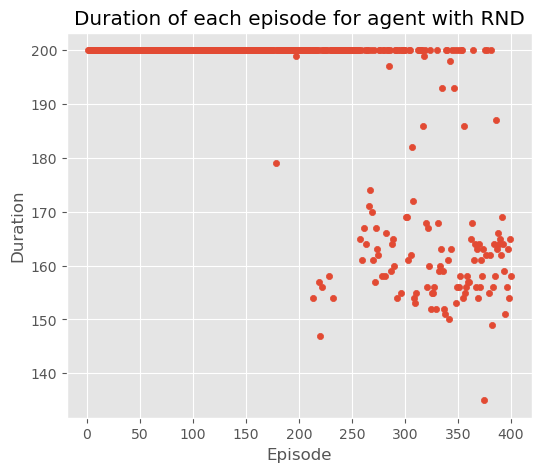

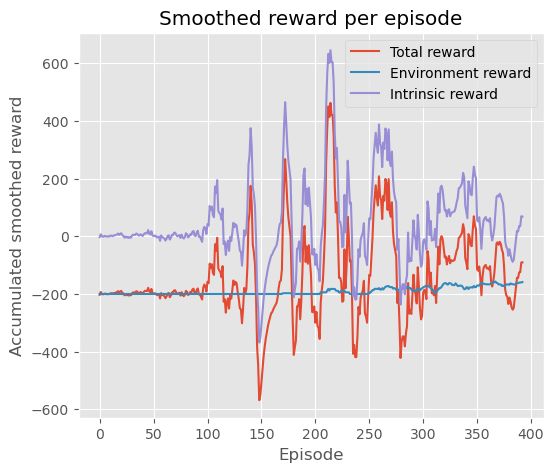

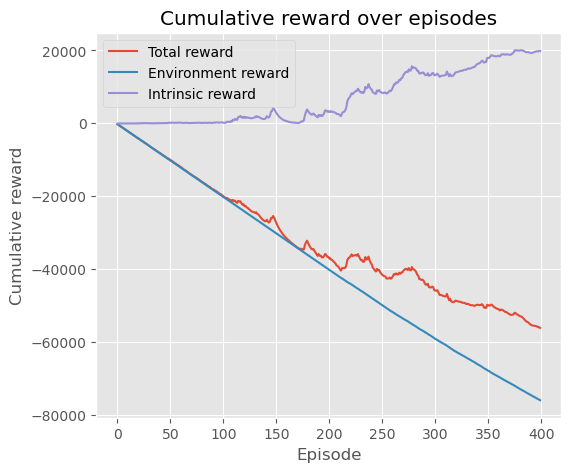

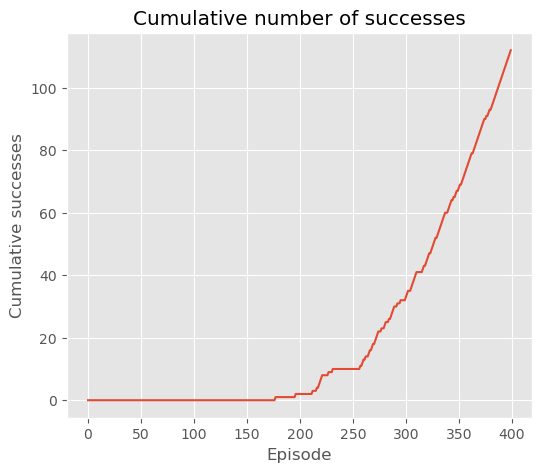

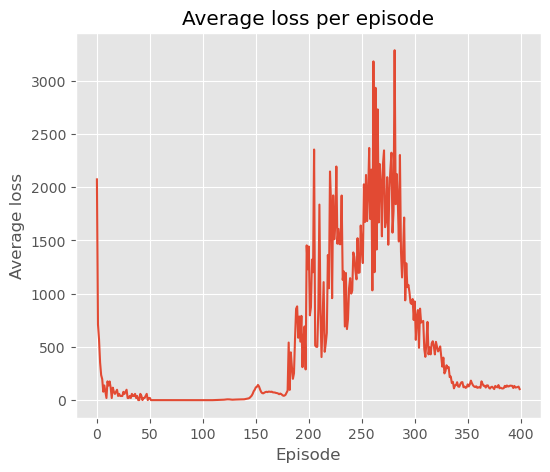

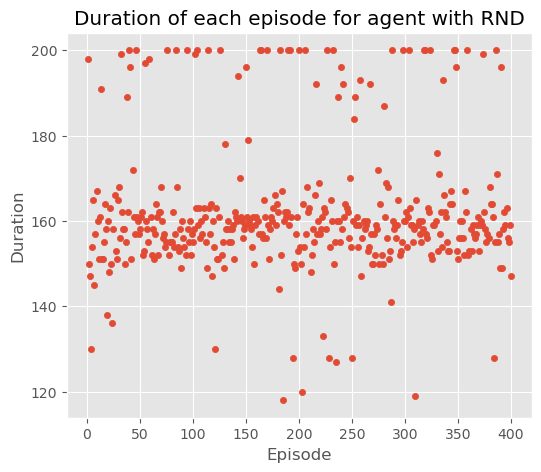

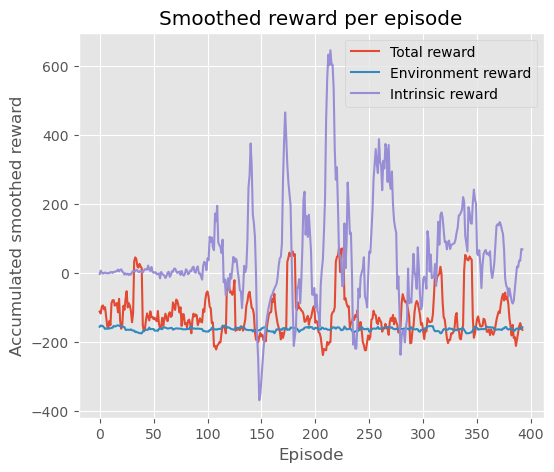

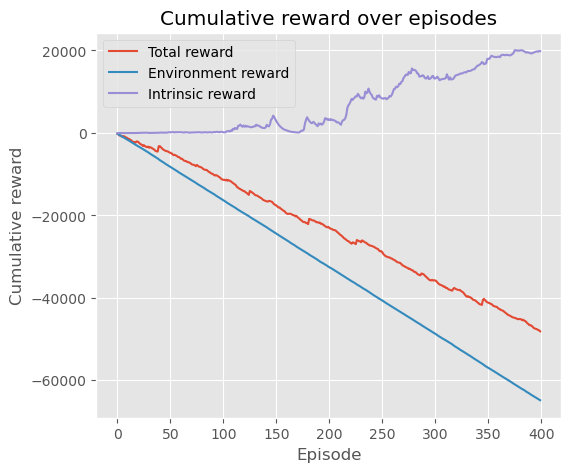

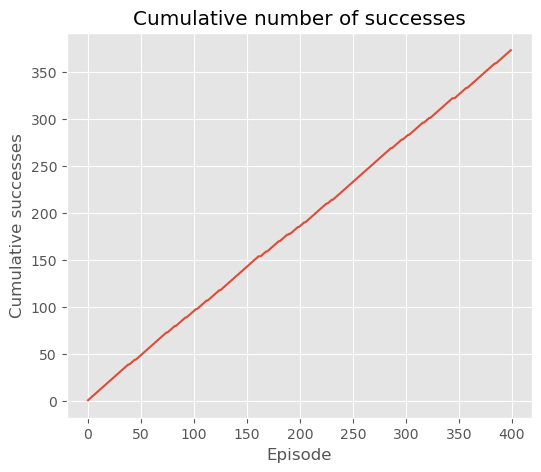

In [187]:
# Train and test the model with no heuristic for the reward 
model_RND = modelWithRND(env=env)
# train the model
model_RND.train()
# test the model
model_RND.test()

## Dyna Agent

In [230]:
class DynaAgent:
    """ Implementation of Dyna Agent. """
    def __init__(self, env=env, k=20, num_episodes=3000, discr_step=[0.025, 0.005], discount_factor=0.95, epsilon_factor=0.997, epsilon_max=0.9, epsilon_min=0.05):
        # Environment itself
        self.env = env
        self.num_episodes = num_episodes
        self.k = k
        
        # Size of bins for discretizing the states
        self.discr_step = discr_step
        
        # Gamma - discoun factor 
        self.discount_factor = discount_factor
        
        # Parameters for epsilong greedy
        self.epsilon_factor = epsilon_factor
        self.epsilon_max = epsilon_max
        self.epsilon_min = epsilon_min
        
        # Discretize coordinate space
        self.discr_coord = np.arange(start=env.observation_space.low[0], step=discr_step[0], stop=env.observation_space.high[0])
        self.discr_speed = np.arange(start=env.observation_space.low[1], step=discr_step[1], stop=env.observation_space.high[1])
        
        # Calculate number of states = (length(self.discr_coord)-1) x (length(self.discr_speed) - 1)
        self.num_states = (self.discr_coord.shape[0] - 1) * (self.discr_speed.shape[0] - 1)
        self.num_actions = env.action_space.n
        
        # Discretize helper
        self.discretize_state = np.arange(self.num_states).reshape(self.discr_coord.shape[0]-1, self.discr_speed.shape[0]-1)
        
        # P Kappa 3D array for storing transition probabilitties (initialized uniformly over state space)
        self.P_kappa = np.zeros((self.num_states, self.num_actions, self.num_states)) + 1/self.num_states
        
        # R kappa 2D array of shape (num_states, num_actions) for storing expected reward
        self.R_kappa = np.zeros((self.num_states, self.num_actions))
        
        # Q-values
        self.Q = np.zeros((self.num_states, self.num_actions))
        
        # For storing already encountered states 
        self.replay_buffer = []

        # Data for plotting
        self.data = {
            "trajectories": [],
            "duration": [],
            "episode_reward": [],
            "success": [],
            "update_steps": [],
            "record_index": [0, int(num_episodes/4), int(num_episodes/2), int(3*num_episodes/4)],
            "record_Q": [None, None, None, None]
        }
        
        self.environment_reward = []

    
    def epsilon_greedy(self, state):
        """ Implements epsilon-greedy policy. """ 
        
        # Take random action if random value is less than epsilon_max
        if np.random.random() < self.epsilon_max:
            return self.env.action_space.sample()
        
        # If not, take the action with largest Q-value from current state
        discretized_index = self.discretize_state_func(state)
        action = np.argmax(self.Q[discretized_index])
            
        return action 
    
    def discretize_state_func(self, state):
        """ Discretize state. """
        no_bin_state = int((state[0] - self.env.observation_space.low[0]) / self.discr_step[0])
        no_bin_speed = int((state[1] - self.env.observation_space.low[1]) / self.discr_step[1])
        
        return self.discretize_state[no_bin_state][no_bin_speed] 
    
    def update_model(self, state_id, next_state_id, action, reward):
        """ Update transition probabilities and expected reward for (state, action) pairs."""
        
        # Update the transition probabiliitu with this new observation
        self.P_kappa[state_id, action, next_state_id] += 1
        self.P_kappa[state_id, action] /= np.sum(self.P_kappa[state_id, action]) 
        
        # Update expected reward: use te formula (1-gamma)*R(state, action) + gamma*r
        updt = (reward - self.R_kappa[state_id, action])/self.P_kappa[state_id, action, next_state_id]
        self.data["update_steps"].append(updt)
        self.R_kappa[state_id, action] += updt
     
    def further_update(self):
        """ Perform further updates for the Q-values of k randomly chosen samples. """  
        for i in range(self.k):
            rand = np.random.randint(len(self.replay_buffer))
            rand_state, rand_action = self.replay_buffer[rand]
            self.Q[rand_state, rand_action] = self.R_kappa[rand_state, rand_action] + self.discount_factor *  np.dot(self.P_kappa[rand_state, rand_action], np.max(self.Q, axis=1))
                
    def train_agent(self):
        """ Train agent. """
        plt.figure(figsize=(5,5))
        plt.title("Agent position against time, for all episodes")
        colors = plt.cm.viridis(np.linspace(0, 1, self.num_episodes + 1))
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=Normalize(vmin=0, vmax=self.num_episodes))
        plt.colorbar(sm, ax=plt.gca(), label='Episode number')
        plt.xlabel("Time")
        plt.ylabel("Position")
        counter = 0
        for i in tqdm(range(self.num_episodes)):
            done = False
            state = self.env.reset()[0]
            position = []
            #print(f"Episode number: {i}")
            self.data['trajectories'].append([])
            accum_reward = 0
            while not done:
                # Transition - sample action according to the epsilon_greedy policy
                action = self.epsilon_greedy(state)
                
                # Observe next_state, reward, terminated, truncated 
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                accum_reward += reward
                
                # Discretize state and next_state (obtain their index in the respective matrices)
                state_id = self.discretize_state_func(state)
                next_state_id = self.discretize_state_func(next_state)
                
                # Update the model of transition probabilities and the expected reward
                self.update_model(state_id, next_state_id, action, reward)
                
                # Set done 
                done = terminated or truncated
                if terminated:
                    print("Goal found!")
                    counter += 1
                    self.data["success"].append(1)
                if truncated:
                    self.data["success"].append(0)
                
                # Update the Q values of the state using the formula
                self.Q[state_id, action] = self.R_kappa[state_id, action] + self.discount_factor * np.dot(self.P_kappa[state_id, action, :], np.max(self.Q, axis=1))
                
                # Add state to the buffer
                self.replay_buffer.append((state_id, action))
                
                # Perform further updates for the Q-values of k randomly chosen 
                self.further_update()
                
                # Update epsilon
                self.epsilon_max = max(self.epsilon_min, self.epsilon_max * self.epsilon_factor)  
                
                # Store position
                position.append(state[0])
                
                # Put next state as current
                state = next_state 
                self.data['trajectories'][i].append([state])
            plt.plot(position, color=colors[i])
            self.data['duration'].append(len(position))
            self.data['episode_reward'].append(accum_reward) 
            if i in self.data['record_index']:
                self.data['record_Q'][int(i/self.data["record_index"][1])] = self.Q.copy()
    
    def test(self, episodes_test, seeds):
        """ Testing the agent. """    
        c = 0   
        for episode in range(episodes_test):

            state = self.env.reset(seed=seeds[episode].item())
            state = state[0]
            done = False
            episode_reward = 0
            print("Episode: ", episode)
            
            while not done:
                action = np.argmax(self.Q[self.discretize_state_func(state)])
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                if terminated:
                    print("Goal found!")
                    c+=1
                    
                state = next_state
                episode_reward += reward 
                
            self.environment_reward.append(episode_reward)   
        return c/episodes_test  

Train each of the models for comparison.

In [195]:
# Generate random set of seeds for testing
seeds = np.random.randint(0, 2**32 - 1, 1000)

In [200]:
type(seeds[0].item())

int

Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
Episode number: 36
Episode number: 37
Episode number: 38
Episode number: 39
Episode number: 40
Episode number: 41
Episode number: 42
Episode number: 43
Episode number: 44
Episode number: 45
Episode number: 46
Episode number: 47
Episode number: 48
Episode number: 49
Episode number: 50
Episode number: 51
Episode number: 52
Epi

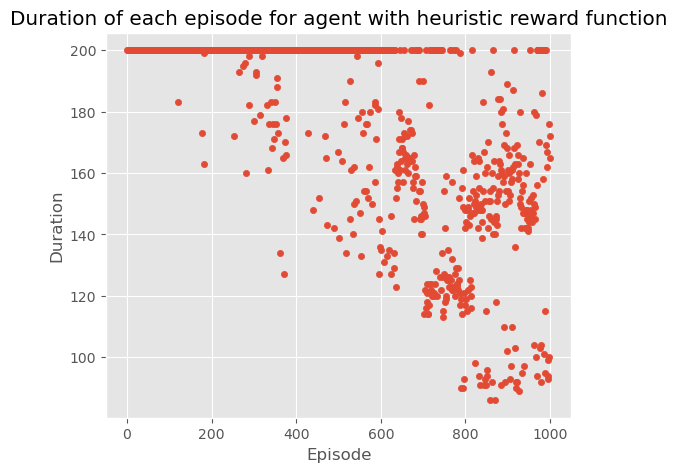

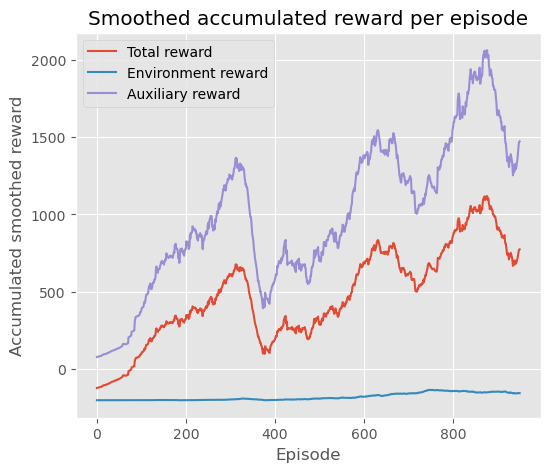

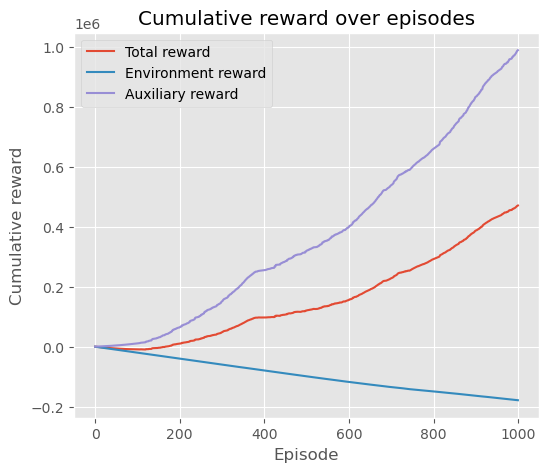

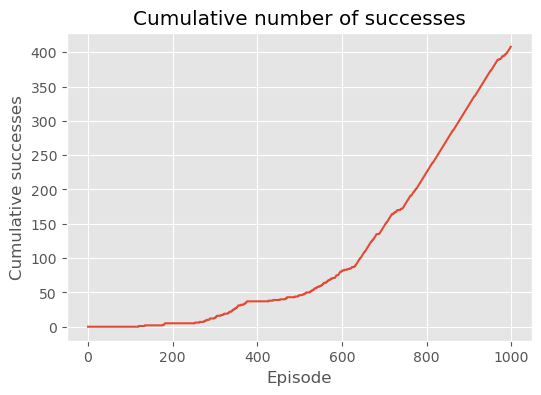

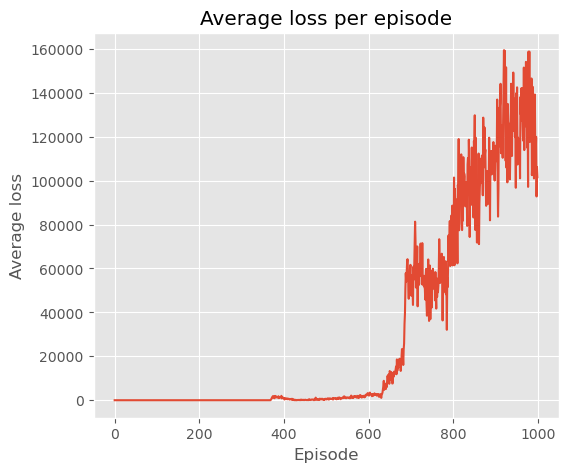

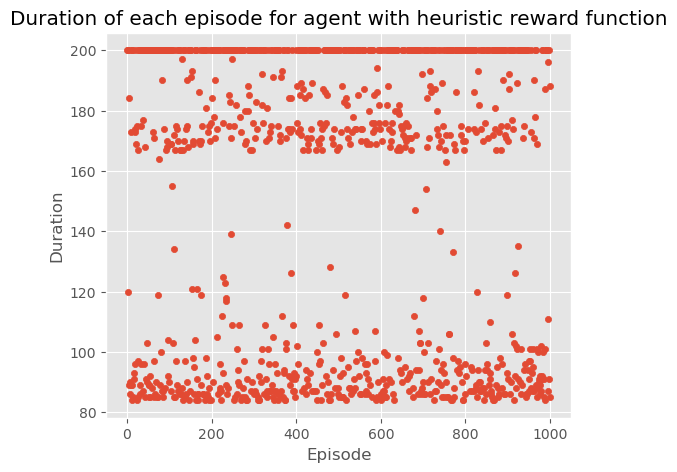

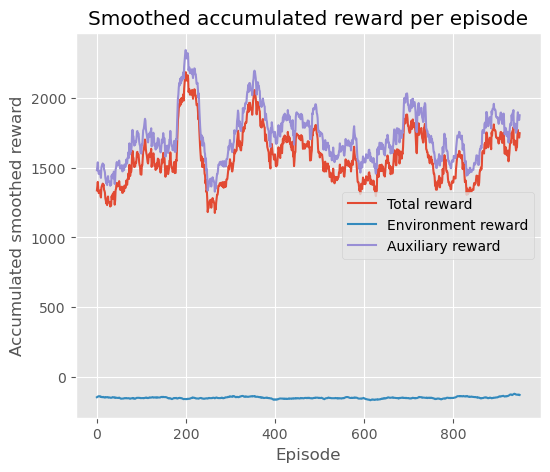

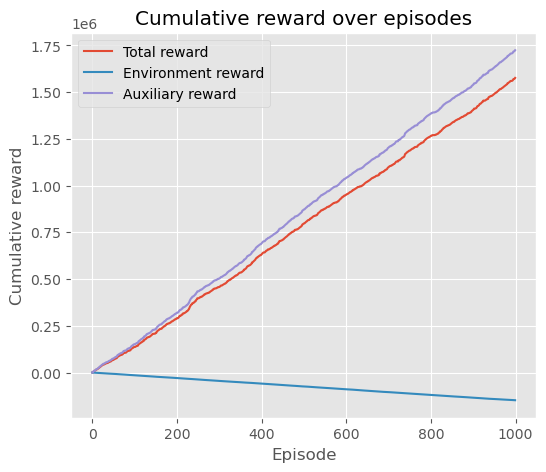

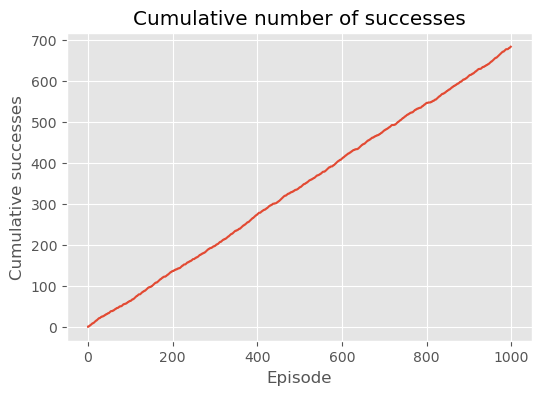

In [210]:
# DQN auxiliary
DQN_auxiliary = modelWithHeuristic(env=env)
DQN_auxiliary.train()
environment_reward_training1 = DQN_auxiliary.environment_reward_record
DQN_auxiliary.test(seeds=seeds)
environment_reward_testing1 = DQN_auxiliary.environment_reward_record

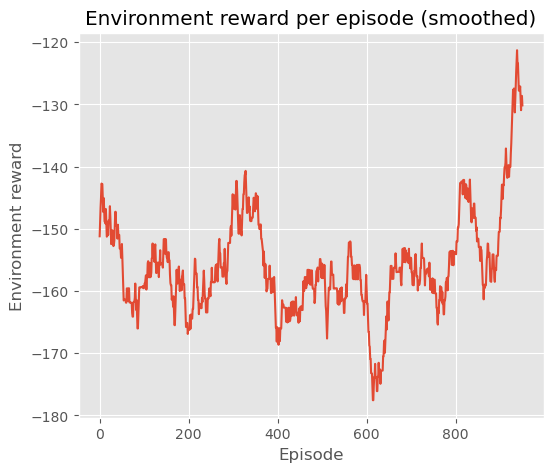

In [203]:
# plot of environment reward during training DQN aux
smoothed_environment_reward1 = np.convolve(environment_reward_testing1, np.ones(50)/50, mode='valid')
plt.figure(figsize=(6, 5))
plt.plot(smoothed_environment_reward1)
plt.title('Environment reward per episode (smoothed)')
plt.xlabel('Episode')
plt.ylabel('Environment reward')
plt.grid(visible=True)

Episode number: 0
Episode number: 1
Episode number: 2
Episode number: 3
Episode number: 4
Episode number: 5
Episode number: 6
Episode number: 7
Episode number: 8
Episode number: 9
Episode number: 10
Episode number: 11
Episode number: 12
Episode number: 13
Episode number: 14
Episode number: 15
Episode number: 16
Episode number: 17
Episode number: 18
Episode number: 19
Episode number: 20
Episode number: 21
Episode number: 22
Episode number: 23
Episode number: 24
Episode number: 25
Episode number: 26
Episode number: 27
Episode number: 28
Episode number: 29
Episode number: 30
Episode number: 31
Episode number: 32
Episode number: 33
Episode number: 34
Episode number: 35
Episode number: 36
Episode number: 37
Episode number: 38
Episode number: 39
Episode number: 40
Episode number: 41
Episode number: 42
Episode number: 43
Episode number: 44
Episode number: 45
Episode number: 46
Episode number: 47
Episode number: 48
Episode number: 49
Episode number: 50
Episode number: 51
Episode number: 52
Epi

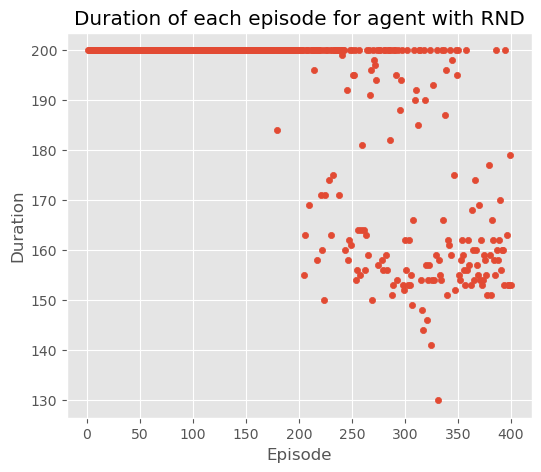

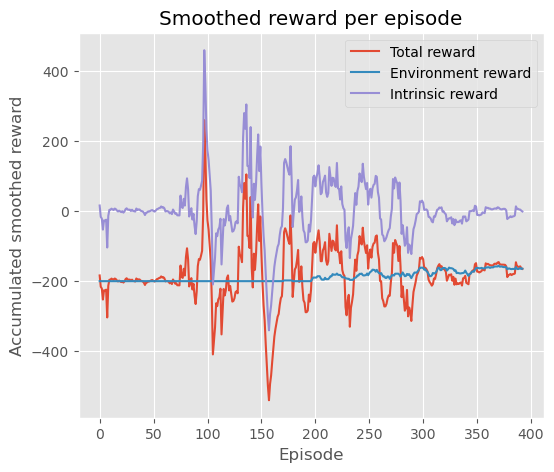

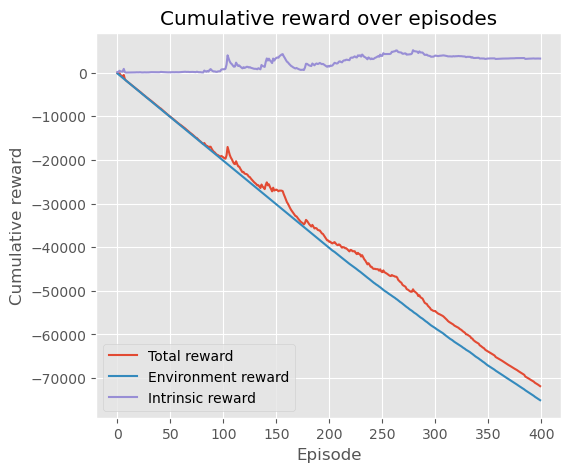

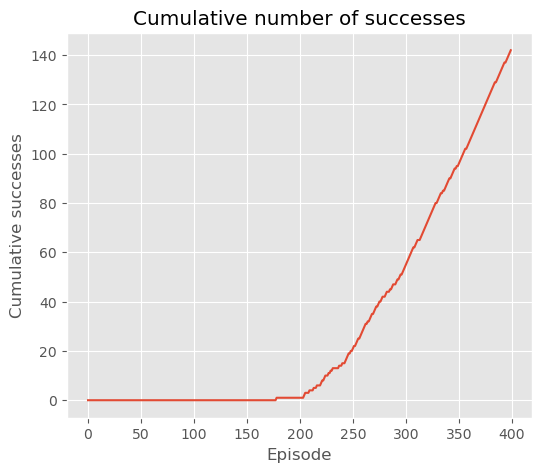

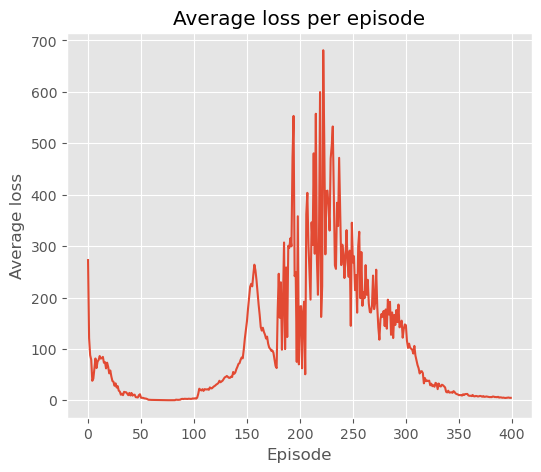

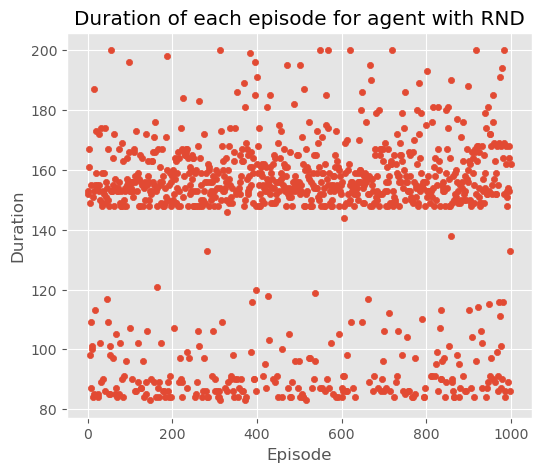

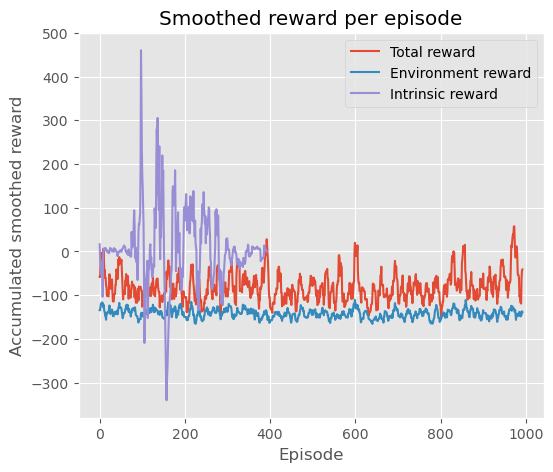

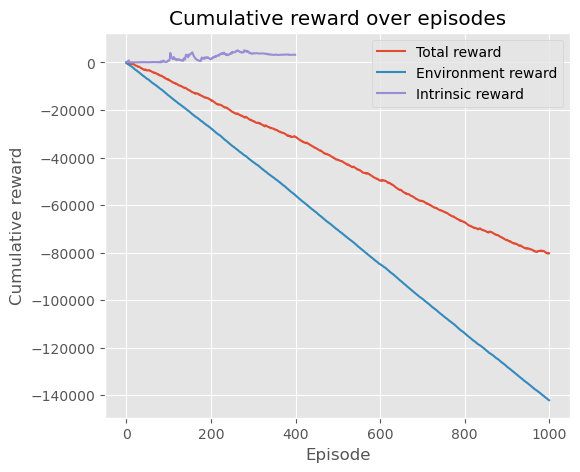

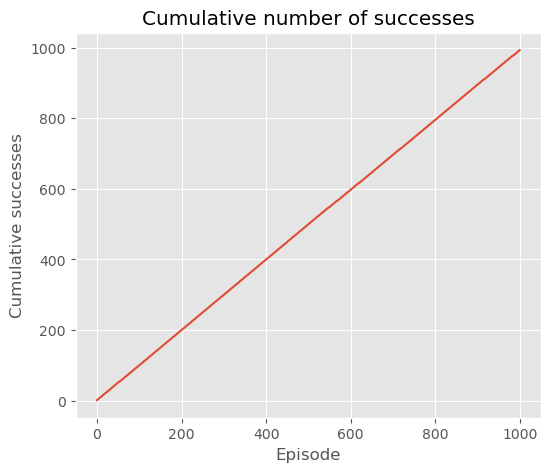

In [206]:
model_RND = modelWithRND(env=env)
model_RND.train()
environment_reward_tr1_rnd = model_RND.environment_reward_record
model_RND.test(seeds=seeds)
environment_reward_te1_rnd = model_RND.environment_reward_record

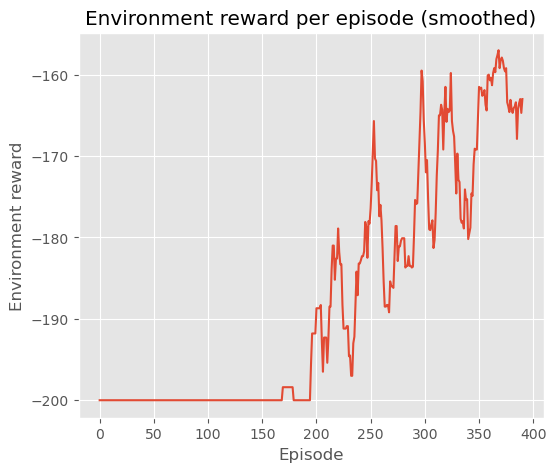

In [212]:
# plot of environment reward DQN RND
smoothed_environment_reward2 = np.convolve(environment_reward_tr1_rnd, np.ones(10)/10, mode='valid')

plt.figure(figsize=(6, 5))
plt.plot(smoothed_environment_reward2)
plt.title('Environment reward per episode (smoothed)')
plt.xlabel('Episode')
plt.ylabel('Environment reward')
plt.grid(visible=True)

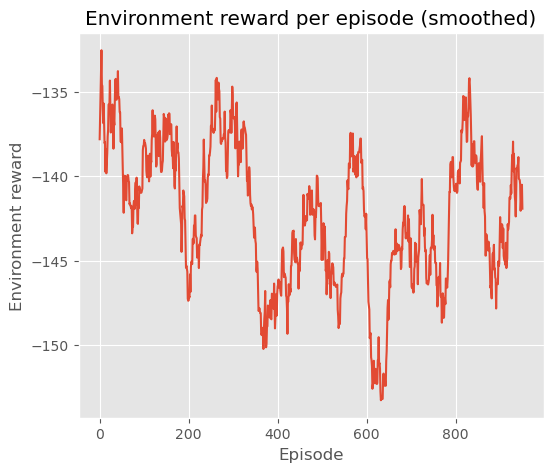

In [209]:
# plot of environment reward DQN RND
smoothed_environment_reward2 = np.convolve(environment_reward_te1_rnd, np.ones(50)/50, mode='valid')

plt.figure(figsize=(6, 5))
plt.plot(smoothed_environment_reward2)
plt.title('Environment reward per episode (smoothed)')
plt.xlabel('Episode')
plt.ylabel('Environment reward')
plt.grid(visible=True)

  9%|▉         | 266/3000 [00:29<05:00,  9.11it/s]

Goal found!


  9%|▉         | 271/3000 [00:30<05:00,  9.09it/s]

Goal found!


  9%|▉         | 276/3000 [00:30<04:57,  9.17it/s]

Goal found!


  9%|▉         | 283/3000 [00:31<04:49,  9.40it/s]

Goal found!
Goal found!


 10%|▉         | 289/3000 [00:32<04:48,  9.41it/s]

Goal found!


 13%|█▎        | 387/3000 [00:43<04:49,  9.03it/s]

Goal found!


 13%|█▎        | 400/3000 [00:44<04:47,  9.05it/s]

Goal found!


 14%|█▎        | 408/3000 [00:45<04:48,  8.98it/s]

Goal found!


 14%|█▎        | 410/3000 [00:45<04:59,  8.66it/s]

Goal found!


 14%|█▍        | 416/3000 [00:46<04:38,  9.28it/s]

Goal found!


 14%|█▍        | 421/3000 [00:46<04:14, 10.12it/s]

Goal found!
Goal found!
Goal found!


 14%|█▍        | 427/3000 [00:47<04:12, 10.19it/s]

Goal found!
Goal found!
Goal found!


 14%|█▍        | 429/3000 [00:47<04:26,  9.66it/s]

Goal found!
Goal found!


 14%|█▍        | 433/3000 [00:48<04:33,  9.37it/s]

Goal found!


 15%|█▍        | 438/3000 [00:48<06:19,  6.75it/s]

Goal found!


 15%|█▍        | 443/3000 [00:49<05:30,  7.74it/s]

Goal found!
Goal found!


 15%|█▍        | 445/3000 [00:49<05:06,  8.34it/s]

Goal found!


 15%|█▍        | 447/3000 [00:49<04:53,  8.69it/s]

Goal found!
Goal found!


 15%|█▍        | 449/3000 [00:50<04:42,  9.02it/s]

Goal found!


 15%|█▌        | 453/3000 [00:50<04:35,  9.24it/s]

Goal found!


 15%|█▌        | 456/3000 [00:50<04:49,  8.80it/s]

Goal found!


 15%|█▌        | 462/3000 [00:51<04:26,  9.52it/s]

Goal found!
Goal found!


 16%|█▌        | 465/3000 [00:51<04:37,  9.14it/s]

Goal found!


 16%|█▌        | 469/3000 [00:52<04:22,  9.64it/s]

Goal found!


 17%|█▋        | 499/3000 [00:55<04:35,  9.07it/s]

Goal found!


 17%|█▋        | 501/3000 [00:55<04:46,  8.72it/s]

Goal found!


 17%|█▋        | 510/3000 [00:56<04:22,  9.50it/s]

Goal found!
Goal found!


 17%|█▋        | 514/3000 [00:57<04:22,  9.46it/s]

Goal found!


 17%|█▋        | 519/3000 [00:57<04:15,  9.71it/s]

Goal found!
Goal found!
Goal found!


 17%|█▋        | 521/3000 [00:58<04:10,  9.89it/s]

Goal found!
Goal found!


 18%|█▊        | 525/3000 [00:58<04:24,  9.35it/s]

Goal found!


 18%|█▊        | 530/3000 [00:59<04:30,  9.12it/s]

Goal found!


 19%|█▉        | 565/3000 [01:02<04:29,  9.03it/s]

Goal found!


 19%|█▉        | 573/3000 [01:03<04:28,  9.04it/s]

Goal found!


 19%|█▉        | 580/3000 [01:04<04:17,  9.40it/s]

Goal found!
Goal found!


 20%|█▉        | 590/3000 [01:05<04:23,  9.15it/s]

Goal found!


 20%|█▉        | 593/3000 [01:06<04:12,  9.51it/s]

Goal found!
Goal found!


 20%|█▉        | 595/3000 [01:06<04:24,  9.08it/s]

Goal found!


 20%|█▉        | 599/3000 [01:06<04:07,  9.70it/s]

Goal found!
Goal found!


 20%|██        | 606/3000 [01:07<04:04,  9.81it/s]

Goal found!
Goal found!
Goal found!


 20%|██        | 608/3000 [01:07<04:12,  9.48it/s]

Goal found!


 20%|██        | 612/3000 [01:08<04:09,  9.58it/s]

Goal found!
Goal found!


 20%|██        | 614/3000 [01:08<04:06,  9.69it/s]

Goal found!


 21%|██        | 616/3000 [01:08<04:07,  9.64it/s]

Goal found!
Goal found!


 21%|██        | 617/3000 [01:08<04:12,  9.45it/s]

Goal found!


 21%|██        | 621/3000 [01:09<06:34,  6.03it/s]

Goal found!
Goal found!


 21%|██        | 628/3000 [01:10<04:21,  9.08it/s]

Goal found!
Goal found!


 21%|██        | 630/3000 [01:10<04:11,  9.44it/s]

Goal found!


 21%|██        | 632/3000 [01:10<04:14,  9.31it/s]

Goal found!
Goal found!


 21%|██        | 634/3000 [01:10<04:03,  9.72it/s]

Goal found!
Goal found!
Goal found!


 21%|██▏       | 639/3000 [01:11<03:56,  9.99it/s]

Goal found!
Goal found!
Goal found!


 21%|██▏       | 641/3000 [01:11<03:47, 10.38it/s]

Goal found!
Goal found!


 22%|██▏       | 649/3000 [01:12<04:14,  9.22it/s]

Goal found!


 22%|██▏       | 651/3000 [01:12<04:14,  9.25it/s]

Goal found!


 22%|██▏       | 655/3000 [01:13<04:05,  9.56it/s]

Goal found!
Goal found!


 22%|██▏       | 657/3000 [01:13<03:52, 10.09it/s]

Goal found!
Goal found!


 22%|██▏       | 661/3000 [01:13<03:44, 10.42it/s]

Goal found!
Goal found!
Goal found!


 22%|██▏       | 665/3000 [01:13<03:45, 10.37it/s]

Goal found!
Goal found!


 22%|██▏       | 667/3000 [01:14<03:50, 10.13it/s]

Goal found!


 22%|██▏       | 670/3000 [01:14<04:04,  9.52it/s]

Goal found!


 22%|██▎       | 675/3000 [01:15<04:14,  9.13it/s]

Goal found!
Goal found!


 23%|██▎       | 679/3000 [01:15<04:16,  9.06it/s]

Goal found!


 23%|██▎       | 684/3000 [01:16<04:07,  9.37it/s]

Goal found!
Goal found!
Goal found!


 23%|██▎       | 689/3000 [01:16<04:10,  9.24it/s]

Goal found!
Goal found!


 23%|██▎       | 704/3000 [01:18<04:21,  8.77it/s]

Goal found!


 24%|██▎       | 707/3000 [01:18<04:16,  8.94it/s]

Goal found!


 24%|██▍       | 718/3000 [01:19<04:12,  9.03it/s]

Goal found!


 24%|██▍       | 726/3000 [01:20<04:11,  9.03it/s]

Goal found!
Goal found!


 24%|██▍       | 728/3000 [01:20<04:05,  9.25it/s]

Goal found!


 24%|██▍       | 730/3000 [01:21<04:11,  9.01it/s]

Goal found!


 25%|██▍       | 743/3000 [01:22<04:37,  8.13it/s]

Goal found!


 25%|██▍       | 747/3000 [01:23<04:12,  8.91it/s]

Goal found!


 25%|██▌       | 757/3000 [01:24<04:09,  9.01it/s]

Goal found!


 25%|██▌       | 759/3000 [01:24<04:20,  8.61it/s]

Goal found!


 26%|██▌       | 768/3000 [01:25<04:07,  9.04it/s]

Goal found!


 26%|██▌       | 771/3000 [01:25<04:05,  9.06it/s]

Goal found!


 26%|██▌       | 785/3000 [01:27<03:58,  9.30it/s]

Goal found!
Goal found!


 27%|██▋       | 797/3000 [01:28<03:55,  9.34it/s]

Goal found!


 27%|██▋       | 812/3000 [01:30<04:01,  9.06it/s]

Goal found!


 27%|██▋       | 814/3000 [01:30<04:02,  9.01it/s]

Goal found!
Goal found!


 27%|██▋       | 824/3000 [01:31<03:54,  9.26it/s]

Goal found!


 28%|██▊       | 828/3000 [01:32<03:59,  9.09it/s]

Goal found!


 28%|██▊       | 830/3000 [01:32<04:00,  9.04it/s]

Goal found!


 28%|██▊       | 835/3000 [01:33<03:40,  9.81it/s]

Goal found!
Goal found!
Goal found!


 28%|██▊       | 837/3000 [01:33<03:45,  9.61it/s]

Goal found!
Goal found!


 28%|██▊       | 840/3000 [01:33<03:55,  9.19it/s]

Goal found!


 28%|██▊       | 842/3000 [01:33<03:54,  9.20it/s]

Goal found!


 28%|██▊       | 845/3000 [01:34<03:40,  9.77it/s]

Goal found!
Goal found!
Goal found!


 28%|██▊       | 847/3000 [01:34<03:37,  9.92it/s]

Goal found!


 28%|██▊       | 849/3000 [01:34<03:31, 10.19it/s]

Goal found!
Goal found!


 28%|██▊       | 854/3000 [01:35<03:50,  9.32it/s]

Goal found!


 29%|██▊       | 856/3000 [01:35<03:48,  9.37it/s]

Goal found!


 29%|██▊       | 858/3000 [01:35<03:45,  9.50it/s]

Goal found!


 29%|██▊       | 860/3000 [01:35<03:49,  9.30it/s]

Goal found!


 29%|██▉       | 864/3000 [01:36<03:45,  9.47it/s]

Goal found!


 29%|██▉       | 875/3000 [01:37<03:59,  8.87it/s]

Goal found!


 29%|██▉       | 881/3000 [01:38<03:56,  8.97it/s]

Goal found!


 29%|██▉       | 883/3000 [01:38<03:54,  9.02it/s]

Goal found!


 30%|██▉       | 891/3000 [01:39<03:48,  9.25it/s]

Goal found!


 30%|██▉       | 894/3000 [01:39<03:45,  9.33it/s]

Goal found!


 30%|██▉       | 898/3000 [01:39<03:31,  9.94it/s]

Goal found!
Goal found!
Goal found!


 30%|███       | 900/3000 [01:40<03:33,  9.84it/s]

Goal found!


 30%|███       | 906/3000 [01:40<03:39,  9.54it/s]

Goal found!
Goal found!
Goal found!


 30%|███       | 908/3000 [01:40<03:24, 10.24it/s]

Goal found!


 30%|███       | 911/3000 [01:41<03:33,  9.80it/s]

Goal found!


 30%|███       | 914/3000 [01:41<03:26, 10.10it/s]

Goal found!
Goal found!


 31%|███       | 919/3000 [01:42<03:30,  9.89it/s]

Goal found!
Goal found!
Goal found!


 31%|███       | 921/3000 [01:42<03:23, 10.24it/s]

Goal found!
Goal found!


 31%|███       | 924/3000 [01:42<03:30,  9.85it/s]

Goal found!
Goal found!


 31%|███       | 927/3000 [01:42<03:35,  9.62it/s]

Goal found!


 31%|███       | 932/3000 [01:43<03:46,  9.12it/s]

Goal found!


 31%|███       | 935/3000 [01:43<03:48,  9.04it/s]

Goal found!


 31%|███▏      | 939/3000 [01:44<03:44,  9.19it/s]

Goal found!


 32%|███▏      | 963/3000 [01:46<03:41,  9.18it/s]

Goal found!


 32%|███▏      | 972/3000 [01:47<03:47,  8.90it/s]

Goal found!


 33%|███▎      | 978/3000 [01:48<03:20, 10.09it/s]

Goal found!
Goal found!
Goal found!


 33%|███▎      | 980/3000 [01:48<03:20, 10.08it/s]

Goal found!


 33%|███▎      | 982/3000 [01:48<03:23,  9.90it/s]

Goal found!


 33%|███▎      | 984/3000 [01:49<03:32,  9.48it/s]

Goal found!


 33%|███▎      | 987/3000 [01:49<03:33,  9.44it/s]

Goal found!
Goal found!


 33%|███▎      | 989/3000 [01:49<03:15, 10.28it/s]

Goal found!
Goal found!


 33%|███▎      | 995/3000 [01:50<03:18, 10.10it/s]

Goal found!
Goal found!
Goal found!


 33%|███▎      | 999/3000 [01:50<03:16, 10.19it/s]

Goal found!
Goal found!


 33%|███▎      | 1004/3000 [01:51<03:25,  9.73it/s]

Goal found!
Goal found!


 34%|███▎      | 1008/3000 [01:51<03:26,  9.66it/s]

Goal found!
Goal found!
Goal found!


 34%|███▎      | 1012/3000 [01:52<03:22,  9.80it/s]

Goal found!


 34%|███▍      | 1016/3000 [01:52<03:28,  9.50it/s]

Goal found!
Goal found!


 34%|███▍      | 1019/3000 [01:52<03:28,  9.52it/s]

Goal found!


 34%|███▍      | 1022/3000 [01:53<03:26,  9.59it/s]

Goal found!


 34%|███▍      | 1024/3000 [01:53<03:18,  9.95it/s]

Goal found!
Goal found!
Goal found!


 34%|███▍      | 1028/3000 [01:53<03:30,  9.38it/s]

Goal found!


 34%|███▍      | 1031/3000 [01:54<03:23,  9.69it/s]

Goal found!
Goal found!


 34%|███▍      | 1033/3000 [01:54<03:23,  9.65it/s]

Goal found!
Goal found!
Goal found!


 35%|███▍      | 1036/3000 [01:54<03:22,  9.71it/s]

Goal found!
Goal found!


 35%|███▍      | 1039/3000 [01:54<03:12, 10.20it/s]

Goal found!
Goal found!
Goal found!


 35%|███▍      | 1043/3000 [01:55<03:27,  9.44it/s]

Goal found!


 35%|███▍      | 1047/3000 [01:55<03:26,  9.46it/s]

Goal found!
Goal found!
Goal found!


 35%|███▌      | 1051/3000 [01:56<03:16,  9.91it/s]

Goal found!


 35%|███▌      | 1053/3000 [01:56<03:11, 10.16it/s]

Goal found!
Goal found!


 35%|███▌      | 1057/3000 [01:56<03:26,  9.40it/s]

Goal found!


 35%|███▌      | 1058/3000 [01:56<03:28,  9.29it/s]

Goal found!
Goal found!


 36%|███▌      | 1067/3000 [01:57<03:29,  9.23it/s]

Goal found!
Goal found!


 36%|███▌      | 1069/3000 [01:58<03:17,  9.78it/s]

Goal found!
Goal found!


 36%|███▌      | 1072/3000 [01:58<03:20,  9.61it/s]

Goal found!


 36%|███▌      | 1075/3000 [01:58<03:33,  9.01it/s]

Goal found!


 36%|███▌      | 1077/3000 [01:58<03:36,  8.88it/s]

Goal found!
Goal found!


 36%|███▌      | 1081/3000 [01:59<03:26,  9.28it/s]

Goal found!


 36%|███▌      | 1083/3000 [01:59<03:30,  9.09it/s]

Goal found!


 36%|███▌      | 1085/3000 [01:59<03:35,  8.89it/s]

Goal found!


 36%|███▌      | 1087/3000 [02:00<03:40,  8.68it/s]

Goal found!


 36%|███▋      | 1091/3000 [02:00<03:31,  9.04it/s]

Goal found!
Goal found!


 37%|███▋      | 1096/3000 [02:00<03:19,  9.56it/s]

Goal found!
Goal found!
Goal found!


 37%|███▋      | 1098/3000 [02:01<03:28,  9.13it/s]

Goal found!


 37%|███▋      | 1112/3000 [02:02<03:32,  8.89it/s]

Goal found!
Goal found!


 37%|███▋      | 1114/3000 [02:03<03:25,  9.20it/s]

Goal found!


 37%|███▋      | 1117/3000 [02:03<03:14,  9.67it/s]

Goal found!
Goal found!


 37%|███▋      | 1121/3000 [02:03<03:14,  9.67it/s]

Goal found!
Goal found!


 37%|███▋      | 1123/3000 [02:04<03:19,  9.39it/s]

Goal found!


 38%|███▊      | 1126/3000 [02:04<03:26,  9.09it/s]

Goal found!


 38%|███▊      | 1129/3000 [02:04<03:24,  9.13it/s]

Goal found!


 38%|███▊      | 1134/3000 [02:05<03:25,  9.08it/s]

Goal found!


 38%|███▊      | 1138/3000 [02:05<02:57, 10.51it/s]

Goal found!
Goal found!
Goal found!


 38%|███▊      | 1142/3000 [02:06<03:03, 10.12it/s]

Goal found!
Goal found!


 38%|███▊      | 1144/3000 [02:06<03:04, 10.06it/s]

Goal found!
Goal found!


 38%|███▊      | 1146/3000 [02:06<02:56, 10.50it/s]

Goal found!


 38%|███▊      | 1151/3000 [02:06<03:02, 10.16it/s]

Goal found!
Goal found!


 39%|███▊      | 1156/3000 [02:07<03:09,  9.73it/s]

Goal found!


 39%|███▊      | 1159/3000 [02:07<03:03, 10.01it/s]

Goal found!
Goal found!


 39%|███▉      | 1167/3000 [02:08<03:20,  9.13it/s]

Goal found!


 39%|███▉      | 1180/3000 [02:10<03:21,  9.04it/s]

Goal found!


 40%|████      | 1203/3000 [02:12<03:10,  9.43it/s]

Goal found!


 40%|████      | 1206/3000 [02:12<03:03,  9.80it/s]

Goal found!
Goal found!
Goal found!


 40%|████      | 1209/3000 [02:13<03:07,  9.57it/s]

Goal found!


 40%|████      | 1212/3000 [02:13<03:01,  9.84it/s]

Goal found!
Goal found!
Goal found!


 41%|████      | 1217/3000 [02:14<03:08,  9.48it/s]

Goal found!


 41%|████      | 1220/3000 [02:14<03:13,  9.21it/s]

Goal found!


 41%|████      | 1226/3000 [02:15<03:04,  9.63it/s]

Goal found!
Goal found!
Goal found!


 41%|████      | 1229/3000 [02:15<02:55, 10.08it/s]

Goal found!
Goal found!
Goal found!


 41%|████      | 1233/3000 [02:15<03:00,  9.77it/s]

Goal found!


 41%|████▏     | 1240/3000 [02:16<03:09,  9.30it/s]

Goal found!
Goal found!
Goal found!


 41%|████▏     | 1244/3000 [02:16<02:48, 10.40it/s]

Goal found!
Goal found!
Goal found!


 42%|████▏     | 1246/3000 [02:17<02:45, 10.62it/s]

Goal found!
Goal found!
Goal found!


 42%|████▏     | 1248/3000 [02:17<02:39, 10.96it/s]

Goal found!


 42%|████▏     | 1252/3000 [02:17<02:44, 10.61it/s]

Goal found!
Goal found!
Goal found!


 42%|████▏     | 1254/3000 [02:17<02:50, 10.22it/s]

Goal found!


 42%|████▏     | 1256/3000 [02:18<02:52, 10.11it/s]

Goal found!


 42%|████▏     | 1266/3000 [02:19<02:54,  9.92it/s]

Goal found!
Goal found!


 43%|████▎     | 1283/3000 [02:21<03:08,  9.11it/s]

Goal found!


 43%|████▎     | 1302/3000 [02:23<03:27,  8.18it/s]

Goal found!


 44%|████▎     | 1309/3000 [02:24<03:15,  8.65it/s]

Goal found!
Goal found!


 44%|████▎     | 1311/3000 [02:24<03:13,  8.73it/s]

Goal found!


 44%|████▍     | 1313/3000 [02:24<03:04,  9.12it/s]

Goal found!
Goal found!


 44%|████▍     | 1315/3000 [02:24<03:02,  9.23it/s]

Goal found!


 44%|████▍     | 1317/3000 [02:25<03:02,  9.20it/s]

Goal found!


 44%|████▍     | 1321/3000 [02:25<02:54,  9.63it/s]

Goal found!
Goal found!
Goal found!


 44%|████▍     | 1325/3000 [02:25<02:49,  9.89it/s]

Goal found!
Goal found!
Goal found!


 44%|████▍     | 1327/3000 [02:26<02:43, 10.24it/s]

Goal found!
Goal found!


 44%|████▍     | 1332/3000 [02:26<02:45, 10.05it/s]

Goal found!
Goal found!


 44%|████▍     | 1334/3000 [02:26<02:43, 10.18it/s]

Goal found!
Goal found!


 45%|████▍     | 1338/3000 [02:27<02:50,  9.75it/s]

Goal found!
Goal found!


 45%|████▍     | 1344/3000 [02:27<02:52,  9.61it/s]

Goal found!
Goal found!


 45%|████▌     | 1351/3000 [02:28<02:55,  9.39it/s]

Goal found!


 45%|████▌     | 1354/3000 [02:28<03:02,  9.00it/s]

Goal found!


 45%|████▌     | 1358/3000 [02:29<02:59,  9.17it/s]

Goal found!
Goal found!
Goal found!


 45%|████▌     | 1362/3000 [02:29<02:33, 10.64it/s]

Goal found!
Goal found!
Goal found!


 46%|████▌     | 1373/3000 [02:30<03:01,  8.98it/s]

Goal found!


 46%|████▌     | 1379/3000 [02:31<03:21,  8.05it/s]

Goal found!
Goal found!


 46%|████▌     | 1381/3000 [02:32<03:06,  8.69it/s]

Goal found!
Goal found!


 46%|████▌     | 1385/3000 [02:32<02:56,  9.15it/s]

Goal found!
Goal found!


 46%|████▌     | 1387/3000 [02:32<02:44,  9.80it/s]

Goal found!
Goal found!


 46%|████▋     | 1392/3000 [02:33<02:50,  9.42it/s]

Goal found!
Goal found!


 47%|████▋     | 1396/3000 [02:33<02:51,  9.38it/s]

Goal found!


 47%|████▋     | 1399/3000 [02:34<02:57,  9.01it/s]

Goal found!


 47%|████▋     | 1403/3000 [02:34<03:00,  8.83it/s]

Goal found!


 47%|████▋     | 1406/3000 [02:34<02:55,  9.11it/s]

Goal found!
Goal found!


 47%|████▋     | 1411/3000 [02:35<02:52,  9.24it/s]

Goal found!


 47%|████▋     | 1413/3000 [02:35<02:54,  9.08it/s]

Goal found!


 47%|████▋     | 1416/3000 [02:35<02:56,  9.00it/s]

Goal found!


 47%|████▋     | 1419/3000 [02:36<02:58,  8.87it/s]

Goal found!


 47%|████▋     | 1423/3000 [02:36<02:55,  8.97it/s]

Goal found!


 48%|████▊     | 1427/3000 [02:37<02:56,  8.91it/s]

Goal found!


 48%|████▊     | 1438/3000 [02:38<02:46,  9.38it/s]

Goal found!


 48%|████▊     | 1448/3000 [02:39<02:51,  9.07it/s]

Goal found!
Goal found!


 49%|████▊     | 1458/3000 [02:40<02:37,  9.79it/s]

Goal found!
Goal found!


 49%|████▊     | 1461/3000 [02:40<02:45,  9.33it/s]

Goal found!


 49%|████▉     | 1465/3000 [02:41<02:42,  9.45it/s]

Goal found!


 49%|████▉     | 1468/3000 [02:41<02:34,  9.94it/s]

Goal found!
Goal found!
Goal found!


 49%|████▉     | 1470/3000 [02:41<02:29, 10.23it/s]

Goal found!


 49%|████▉     | 1478/3000 [02:42<02:33,  9.92it/s]

Goal found!
Goal found!


 49%|████▉     | 1481/3000 [02:43<02:39,  9.51it/s]

Goal found!
Goal found!


 50%|████▉     | 1485/3000 [02:43<02:40,  9.41it/s]

Goal found!


 50%|████▉     | 1487/3000 [02:43<02:47,  9.05it/s]

Goal found!


 50%|████▉     | 1489/3000 [02:43<02:48,  8.97it/s]

Goal found!


 50%|████▉     | 1491/3000 [02:44<02:47,  9.02it/s]

Goal found!


 50%|█████     | 1501/3000 [02:45<02:33,  9.75it/s]

Goal found!
Goal found!


 50%|█████     | 1504/3000 [02:45<02:40,  9.31it/s]

Goal found!


 50%|█████     | 1506/3000 [02:45<02:31,  9.85it/s]

Goal found!
Goal found!


 50%|█████     | 1508/3000 [02:45<02:38,  9.39it/s]

Goal found!


 50%|█████     | 1511/3000 [02:46<02:43,  9.10it/s]

Goal found!
Goal found!


 51%|█████     | 1517/3000 [02:46<02:41,  9.21it/s]

Goal found!


 51%|█████     | 1519/3000 [02:47<02:29,  9.92it/s]

Goal found!
Goal found!


 51%|█████     | 1523/3000 [02:47<02:33,  9.60it/s]

Goal found!


 51%|█████     | 1527/3000 [02:47<02:27,  9.97it/s]

Goal found!
Goal found!
Goal found!


 51%|█████     | 1530/3000 [02:48<02:24, 10.20it/s]

Goal found!
Goal found!
Goal found!


 51%|█████     | 1532/3000 [02:48<02:29,  9.80it/s]

Goal found!
Goal found!


 51%|█████▏    | 1538/3000 [02:49<02:31,  9.65it/s]

Goal found!


 51%|█████▏    | 1541/3000 [02:49<02:27,  9.92it/s]

Goal found!
Goal found!
Goal found!


 52%|█████▏    | 1546/3000 [02:49<02:26,  9.93it/s]

Goal found!


 52%|█████▏    | 1551/3000 [02:50<02:36,  9.27it/s]

Goal found!
Goal found!


 52%|█████▏    | 1554/3000 [02:50<02:34,  9.39it/s]

Goal found!
Goal found!


 52%|█████▏    | 1566/3000 [02:52<02:37,  9.08it/s]

Goal found!


 52%|█████▏    | 1568/3000 [02:52<02:34,  9.28it/s]

Goal found!
Goal found!
Goal found!


 52%|█████▏    | 1572/3000 [02:52<02:24,  9.87it/s]

Goal found!
Goal found!


 53%|█████▎    | 1579/3000 [02:53<02:34,  9.19it/s]

Goal found!


 53%|█████▎    | 1582/3000 [02:53<02:35,  9.09it/s]

Goal found!


 53%|█████▎    | 1585/3000 [02:54<02:35,  9.11it/s]

Goal found!


 53%|█████▎    | 1589/3000 [02:54<02:35,  9.08it/s]

Goal found!


 53%|█████▎    | 1592/3000 [02:54<02:25,  9.64it/s]

Goal found!
Goal found!


 53%|█████▎    | 1595/3000 [02:55<02:30,  9.35it/s]

Goal found!


 53%|█████▎    | 1600/3000 [02:55<02:24,  9.72it/s]

Goal found!
Goal found!
Goal found!


 53%|█████▎    | 1604/3000 [02:56<02:17, 10.17it/s]

Goal found!
Goal found!


 54%|█████▎    | 1609/3000 [02:56<02:19,  9.97it/s]

Goal found!
Goal found!


 54%|█████▍    | 1614/3000 [02:57<02:23,  9.68it/s]

Goal found!


 54%|█████▍    | 1616/3000 [02:57<02:46,  8.31it/s]

Goal found!
Goal found!


 54%|█████▍    | 1619/3000 [02:57<02:28,  9.28it/s]

Goal found!


 54%|█████▍    | 1626/3000 [02:58<02:25,  9.47it/s]

Goal found!


 54%|█████▍    | 1630/3000 [02:58<02:27,  9.28it/s]

Goal found!


 55%|█████▍    | 1636/3000 [02:59<02:19,  9.77it/s]

Goal found!
Goal found!
Goal found!


 55%|█████▍    | 1640/3000 [03:00<02:22,  9.53it/s]

Goal found!
Goal found!


 55%|█████▍    | 1643/3000 [03:00<02:20,  9.66it/s]

Goal found!
Goal found!


 55%|█████▍    | 1645/3000 [03:00<02:22,  9.53it/s]

Goal found!
Goal found!


 55%|█████▍    | 1648/3000 [03:00<02:20,  9.62it/s]

Goal found!


 55%|█████▌    | 1650/3000 [03:01<02:21,  9.51it/s]

Goal found!
Goal found!


 55%|█████▌    | 1652/3000 [03:01<02:13, 10.09it/s]

Goal found!
Goal found!


 55%|█████▌    | 1656/3000 [03:01<02:14,  9.98it/s]

Goal found!
Goal found!
Goal found!


 55%|█████▌    | 1659/3000 [03:01<02:17,  9.74it/s]

Goal found!


 55%|█████▌    | 1663/3000 [03:02<02:23,  9.32it/s]

Goal found!
Goal found!


 56%|█████▌    | 1667/3000 [03:02<02:21,  9.41it/s]

Goal found!


 56%|█████▌    | 1669/3000 [03:03<02:18,  9.62it/s]

Goal found!


 56%|█████▌    | 1673/3000 [03:03<02:17,  9.67it/s]

Goal found!


 56%|█████▌    | 1675/3000 [03:03<02:17,  9.62it/s]

Goal found!


 56%|█████▌    | 1680/3000 [03:04<02:22,  9.29it/s]

Goal found!
Goal found!


 56%|█████▌    | 1682/3000 [03:04<02:13,  9.88it/s]

Goal found!
Goal found!


 56%|█████▌    | 1685/3000 [03:04<02:18,  9.52it/s]

Goal found!


 56%|█████▋    | 1688/3000 [03:05<02:20,  9.33it/s]

Goal found!


 56%|█████▋    | 1692/3000 [03:05<02:20,  9.28it/s]

Goal found!
Goal found!


 57%|█████▋    | 1698/3000 [03:06<02:16,  9.57it/s]

Goal found!
Goal found!


 57%|█████▋    | 1708/3000 [03:07<02:16,  9.47it/s]

Goal found!


 57%|█████▋    | 1713/3000 [03:07<02:09,  9.95it/s]

Goal found!
Goal found!


 57%|█████▋    | 1718/3000 [03:08<02:09,  9.88it/s]

Goal found!
Goal found!


 57%|█████▋    | 1720/3000 [03:08<02:09,  9.86it/s]

Goal found!


 57%|█████▋    | 1722/3000 [03:08<02:12,  9.62it/s]

Goal found!


 57%|█████▋    | 1724/3000 [03:08<02:14,  9.47it/s]

Goal found!
Goal found!


 58%|█████▊    | 1728/3000 [03:09<02:04, 10.20it/s]

Goal found!
Goal found!


 58%|█████▊    | 1731/3000 [03:09<02:12,  9.57it/s]

Goal found!


 58%|█████▊    | 1734/3000 [03:09<02:06, 10.03it/s]

Goal found!
Goal found!
Goal found!


 58%|█████▊    | 1736/3000 [03:10<02:01, 10.36it/s]

Goal found!
Goal found!
Goal found!


 58%|█████▊    | 1740/3000 [03:10<01:59, 10.54it/s]

Goal found!
Goal found!


 58%|█████▊    | 1742/3000 [03:10<02:04, 10.11it/s]

Goal found!


 58%|█████▊    | 1744/3000 [03:10<02:04, 10.09it/s]

Goal found!


 58%|█████▊    | 1748/3000 [03:11<02:04, 10.10it/s]

Goal found!
Goal found!
Goal found!


 58%|█████▊    | 1750/3000 [03:11<02:03, 10.10it/s]

Goal found!
Goal found!
Goal found!


 58%|█████▊    | 1752/3000 [03:11<01:59, 10.42it/s]

Goal found!
Goal found!


 59%|█████▊    | 1756/3000 [03:12<02:05,  9.90it/s]

Goal found!
Goal found!


 59%|█████▊    | 1760/3000 [03:12<01:58, 10.46it/s]

Goal found!
Goal found!
Goal found!


 59%|█████▉    | 1764/3000 [03:12<02:07,  9.73it/s]

Goal found!


 59%|█████▉    | 1770/3000 [03:13<02:05,  9.77it/s]

Goal found!
Goal found!
Goal found!


 59%|█████▉    | 1775/3000 [03:13<02:03,  9.89it/s]

Goal found!


 60%|█████▉    | 1787/3000 [03:15<02:10,  9.29it/s]

Goal found!


 60%|██████    | 1801/3000 [03:16<02:07,  9.40it/s]

Goal found!
Goal found!


 60%|██████    | 1804/3000 [03:17<02:06,  9.48it/s]

Goal found!


 60%|██████    | 1811/3000 [03:17<02:01,  9.81it/s]

Goal found!
Goal found!


 60%|██████    | 1814/3000 [03:18<02:05,  9.47it/s]

Goal found!


 61%|██████    | 1816/3000 [03:18<02:02,  9.66it/s]

Goal found!


 61%|██████    | 1820/3000 [03:18<02:07,  9.27it/s]

Goal found!
Goal found!


 61%|██████    | 1822/3000 [03:19<02:05,  9.35it/s]

Goal found!
Goal found!


 61%|██████    | 1824/3000 [03:19<02:05,  9.34it/s]

Goal found!
Goal found!


 61%|██████    | 1827/3000 [03:19<02:02,  9.59it/s]

Goal found!
Goal found!
Goal found!


 61%|██████    | 1829/3000 [03:19<01:54, 10.25it/s]

Goal found!


 61%|██████    | 1834/3000 [03:20<01:59,  9.78it/s]

Goal found!


 61%|██████▏   | 1840/3000 [03:20<02:02,  9.43it/s]

Goal found!
Goal found!


 61%|██████▏   | 1842/3000 [03:21<01:53, 10.16it/s]

Goal found!
Goal found!


 62%|██████▏   | 1845/3000 [03:21<01:58,  9.71it/s]

Goal found!


 63%|██████▎   | 1879/3000 [03:25<02:04,  9.02it/s]

Goal found!


 63%|██████▎   | 1896/3000 [03:27<02:07,  8.65it/s]

Goal found!


 63%|██████▎   | 1898/3000 [03:27<02:06,  8.73it/s]

Goal found!


 64%|██████▎   | 1907/3000 [03:28<01:55,  9.49it/s]

Goal found!


 64%|██████▎   | 1909/3000 [03:29<01:56,  9.39it/s]

Goal found!
Goal found!


 64%|██████▎   | 1911/3000 [03:29<01:48, 10.02it/s]

Goal found!
Goal found!


 64%|██████▍   | 1914/3000 [03:29<01:55,  9.42it/s]

Goal found!


 64%|██████▍   | 1916/3000 [03:29<01:52,  9.62it/s]

Goal found!
Goal found!


 64%|██████▍   | 1923/3000 [03:30<02:00,  8.92it/s]

Goal found!


 64%|██████▍   | 1927/3000 [03:31<01:58,  9.05it/s]

Goal found!


 64%|██████▍   | 1930/3000 [03:31<01:58,  9.03it/s]

Goal found!
Goal found!


 64%|██████▍   | 1934/3000 [03:31<01:41, 10.47it/s]

Goal found!
Goal found!
Goal found!


 65%|██████▍   | 1937/3000 [03:32<01:46,  9.94it/s]

Goal found!
Goal found!
Goal found!


 65%|██████▍   | 1939/3000 [03:32<01:41, 10.42it/s]

Goal found!


 65%|██████▍   | 1943/3000 [03:32<01:46,  9.88it/s]

Goal found!


 65%|██████▍   | 1945/3000 [03:32<01:44, 10.11it/s]

Goal found!
Goal found!
Goal found!


 65%|██████▍   | 1947/3000 [03:33<01:43, 10.15it/s]

Goal found!
Goal found!


 65%|██████▌   | 1951/3000 [03:33<01:40, 10.39it/s]

Goal found!
Goal found!
Goal found!


 65%|██████▌   | 1953/3000 [03:33<01:42, 10.19it/s]

Goal found!
Goal found!
Goal found!


 65%|██████▌   | 1955/3000 [03:33<01:41, 10.34it/s]

Goal found!


 65%|██████▌   | 1959/3000 [03:34<01:42, 10.18it/s]

Goal found!
Goal found!
Goal found!


 65%|██████▌   | 1963/3000 [03:34<01:38, 10.57it/s]

Goal found!
Goal found!
Goal found!


 66%|██████▌   | 1965/3000 [03:34<01:37, 10.67it/s]

Goal found!


 66%|██████▌   | 1969/3000 [03:35<01:39, 10.36it/s]

Goal found!


 66%|██████▌   | 1975/3000 [03:35<01:44,  9.80it/s]

Goal found!


 66%|██████▌   | 1986/3000 [03:37<01:50,  9.15it/s]

Goal found!


 66%|██████▋   | 1995/3000 [03:38<01:52,  8.94it/s]

Goal found!


 67%|██████▋   | 2005/3000 [03:39<01:49,  9.12it/s]

Goal found!
Goal found!


 67%|██████▋   | 2009/3000 [03:39<01:45,  9.36it/s]

Goal found!


 67%|██████▋   | 2011/3000 [03:39<01:47,  9.17it/s]

Goal found!


 67%|██████▋   | 2015/3000 [03:40<01:45,  9.35it/s]

Goal found!


 67%|██████▋   | 2018/3000 [03:40<01:42,  9.56it/s]

Goal found!


 68%|██████▊   | 2030/3000 [03:41<01:41,  9.59it/s]

Goal found!
Goal found!


 68%|██████▊   | 2033/3000 [03:42<01:44,  9.24it/s]

Goal found!


 68%|██████▊   | 2036/3000 [03:42<01:45,  9.14it/s]

Goal found!


 68%|██████▊   | 2039/3000 [03:42<01:45,  9.09it/s]

Goal found!


 68%|██████▊   | 2043/3000 [03:43<01:45,  9.04it/s]

Goal found!


 68%|██████▊   | 2046/3000 [03:43<01:40,  9.45it/s]

Goal found!


 68%|██████▊   | 2050/3000 [03:44<01:35,  9.99it/s]

Goal found!
Goal found!
Goal found!


 68%|██████▊   | 2052/3000 [03:44<01:37,  9.68it/s]

Goal found!


 69%|██████▊   | 2057/3000 [03:44<01:35,  9.88it/s]

Goal found!
Goal found!


 69%|██████▊   | 2060/3000 [03:45<01:39,  9.42it/s]

Goal found!


 69%|██████▉   | 2064/3000 [03:45<01:35,  9.84it/s]

Goal found!
Goal found!
Goal found!


 69%|██████▉   | 2068/3000 [03:45<01:32, 10.11it/s]

Goal found!
Goal found!
Goal found!


 69%|██████▉   | 2070/3000 [03:46<01:28, 10.51it/s]

Goal found!
Goal found!
Goal found!


 69%|██████▉   | 2072/3000 [03:46<01:29, 10.42it/s]

Goal found!
Goal found!


 69%|██████▉   | 2076/3000 [03:46<01:31, 10.10it/s]

Goal found!
Goal found!


 69%|██████▉   | 2078/3000 [03:46<01:31, 10.05it/s]

Goal found!


 69%|██████▉   | 2080/3000 [03:47<01:33,  9.79it/s]

Goal found!


 69%|██████▉   | 2083/3000 [03:47<01:36,  9.46it/s]

Goal found!
Goal found!


 70%|██████▉   | 2086/3000 [03:47<01:35,  9.61it/s]

Goal found!


 70%|██████▉   | 2090/3000 [03:48<01:32,  9.82it/s]

Goal found!
Goal found!


 70%|██████▉   | 2091/3000 [03:48<01:33,  9.70it/s]

Goal found!
Goal found!


 70%|██████▉   | 2096/3000 [03:48<01:31,  9.83it/s]

Goal found!
Goal found!
Goal found!


 70%|██████▉   | 2098/3000 [03:48<01:26, 10.42it/s]

Goal found!


 70%|███████   | 2103/3000 [03:49<01:29,  9.98it/s]

Goal found!
Goal found!


 70%|███████   | 2107/3000 [03:49<01:27, 10.24it/s]

Goal found!
Goal found!
Goal found!


 70%|███████   | 2109/3000 [03:50<01:27, 10.17it/s]

Goal found!
Goal found!


 70%|███████   | 2112/3000 [03:50<01:30,  9.77it/s]

Goal found!


 71%|███████   | 2116/3000 [03:50<01:29,  9.87it/s]

Goal found!
Goal found!


 71%|███████   | 2118/3000 [03:51<01:36,  9.17it/s]

Goal found!
Goal found!
Goal found!


 71%|███████   | 2121/3000 [03:51<01:35,  9.21it/s]

Goal found!
Goal found!


 71%|███████   | 2124/3000 [03:51<01:28,  9.85it/s]

Goal found!
Goal found!
Goal found!


 71%|███████   | 2126/3000 [03:51<01:33,  9.31it/s]

Goal found!


 71%|███████   | 2128/3000 [03:52<01:33,  9.31it/s]

Goal found!


 71%|███████   | 2137/3000 [03:53<01:37,  8.85it/s]

Goal found!
Goal found!


 71%|███████▏  | 2143/3000 [03:53<01:32,  9.23it/s]

Goal found!
Goal found!


 72%|███████▏  | 2145/3000 [03:53<01:32,  9.20it/s]

Goal found!
Goal found!
Goal found!


 72%|███████▏  | 2150/3000 [03:54<01:30,  9.42it/s]

Goal found!
Goal found!


 72%|███████▏  | 2156/3000 [03:55<01:23, 10.15it/s]

Goal found!
Goal found!
Goal found!


 72%|███████▏  | 2159/3000 [03:55<01:24,  9.90it/s]

Goal found!
Goal found!


 72%|███████▏  | 2163/3000 [03:55<01:26,  9.72it/s]

Goal found!


 72%|███████▏  | 2166/3000 [03:56<01:28,  9.43it/s]

Goal found!
Goal found!


 72%|███████▏  | 2169/3000 [03:56<01:33,  8.93it/s]

Goal found!


 72%|███████▏  | 2172/3000 [03:56<01:25,  9.66it/s]

Goal found!
Goal found!


 72%|███████▎  | 2175/3000 [03:57<01:23,  9.84it/s]

Goal found!
Goal found!


 73%|███████▎  | 2186/3000 [03:58<01:30,  8.97it/s]

Goal found!


 73%|███████▎  | 2189/3000 [03:58<01:20, 10.02it/s]

Goal found!
Goal found!
Goal found!


 73%|███████▎  | 2192/3000 [03:58<01:15, 10.65it/s]

Goal found!
Goal found!
Goal found!


 73%|███████▎  | 2194/3000 [03:59<01:20,  9.99it/s]

Goal found!


 74%|███████▍  | 2213/3000 [04:01<01:25,  9.18it/s]

Goal found!


 74%|███████▍  | 2221/3000 [04:02<01:33,  8.36it/s]

Goal found!
Goal found!


 74%|███████▍  | 2228/3000 [04:03<01:24,  9.10it/s]

Goal found!
Goal found!


 74%|███████▍  | 2230/3000 [04:03<01:22,  9.37it/s]

Goal found!
Goal found!


 74%|███████▍  | 2233/3000 [04:03<01:23,  9.22it/s]

Goal found!
Goal found!


 75%|███████▍  | 2238/3000 [04:04<01:22,  9.22it/s]

Goal found!
Goal found!


 75%|███████▍  | 2241/3000 [04:04<01:16,  9.95it/s]

Goal found!
Goal found!
Goal found!


 75%|███████▍  | 2244/3000 [04:04<01:14, 10.08it/s]

Goal found!
Goal found!


 75%|███████▍  | 2247/3000 [04:05<01:11, 10.51it/s]

Goal found!
Goal found!
Goal found!


 75%|███████▌  | 2251/3000 [04:05<01:11, 10.49it/s]

Goal found!
Goal found!


 75%|███████▌  | 2253/3000 [04:05<01:13, 10.12it/s]

Goal found!


 75%|███████▌  | 2255/3000 [04:06<01:14, 10.03it/s]

Goal found!


 75%|███████▌  | 2258/3000 [04:06<01:15,  9.78it/s]

Goal found!


 75%|███████▌  | 2262/3000 [04:06<01:14,  9.88it/s]

Goal found!
Goal found!
Goal found!


 76%|███████▌  | 2270/3000 [04:07<01:18,  9.25it/s]

Goal found!
Goal found!


 76%|███████▌  | 2275/3000 [04:08<01:14,  9.78it/s]

Goal found!


 76%|███████▌  | 2277/3000 [04:08<01:14,  9.77it/s]

Goal found!
Goal found!


 76%|███████▌  | 2281/3000 [04:08<01:09, 10.33it/s]

Goal found!
Goal found!


 76%|███████▌  | 2283/3000 [04:08<01:09, 10.29it/s]

Goal found!
Goal found!


 76%|███████▌  | 2287/3000 [04:09<01:09, 10.21it/s]

Goal found!


 76%|███████▋  | 2289/3000 [04:09<01:09, 10.28it/s]

Goal found!
Goal found!


 76%|███████▋  | 2295/3000 [04:10<01:12,  9.67it/s]

Goal found!


 77%|███████▋  | 2299/3000 [04:10<01:15,  9.26it/s]

Goal found!


 77%|███████▋  | 2310/3000 [04:11<01:16,  9.07it/s]

Goal found!


 77%|███████▋  | 2318/3000 [04:12<01:14,  9.13it/s]

Goal found!
Goal found!


 77%|███████▋  | 2322/3000 [04:13<01:50,  6.14it/s]

Goal found!


 77%|███████▋  | 2324/3000 [04:13<01:31,  7.37it/s]

Goal found!


 78%|███████▊  | 2327/3000 [04:13<01:25,  7.85it/s]

Goal found!
Goal found!


 78%|███████▊  | 2329/3000 [04:14<01:20,  8.34it/s]

Goal found!
Goal found!


 78%|███████▊  | 2333/3000 [04:14<01:18,  8.50it/s]

Goal found!


 78%|███████▊  | 2336/3000 [04:14<01:14,  8.95it/s]

Goal found!
Goal found!


 78%|███████▊  | 2340/3000 [04:15<01:13,  8.99it/s]

Goal found!
Goal found!


 78%|███████▊  | 2343/3000 [04:15<01:13,  8.95it/s]

Goal found!
Goal found!


 78%|███████▊  | 2346/3000 [04:16<01:09,  9.43it/s]

Goal found!


 78%|███████▊  | 2349/3000 [04:16<01:11,  9.11it/s]

Goal found!
Goal found!


 78%|███████▊  | 2351/3000 [04:16<01:09,  9.28it/s]

Goal found!
Goal found!


 78%|███████▊  | 2353/3000 [04:16<01:10,  9.20it/s]

Goal found!


 79%|███████▊  | 2358/3000 [04:17<01:07,  9.54it/s]

Goal found!
Goal found!


 79%|███████▊  | 2361/3000 [04:17<01:08,  9.27it/s]

Goal found!


 79%|███████▉  | 2363/3000 [04:17<01:09,  9.19it/s]

Goal found!


 79%|███████▉  | 2370/3000 [04:18<01:05,  9.56it/s]

Goal found!


 79%|███████▉  | 2374/3000 [04:19<01:09,  9.06it/s]

Goal found!


 79%|███████▉  | 2383/3000 [04:20<01:08,  9.05it/s]

Goal found!


 81%|████████  | 2422/3000 [04:24<01:04,  9.03it/s]

Goal found!


 81%|████████  | 2424/3000 [04:24<01:03,  9.04it/s]

Goal found!


 81%|████████▏ | 2438/3000 [04:26<01:15,  7.43it/s]

Goal found!


 81%|████████▏ | 2440/3000 [04:26<01:07,  8.29it/s]

Goal found!
Goal found!


 82%|████████▏ | 2454/3000 [04:28<01:00,  9.09it/s]

Goal found!


 82%|████████▏ | 2457/3000 [04:28<00:54,  9.89it/s]

Goal found!
Goal found!
Goal found!


 82%|████████▏ | 2461/3000 [04:28<00:51, 10.48it/s]

Goal found!
Goal found!


 82%|████████▏ | 2464/3000 [04:29<00:54,  9.77it/s]

Goal found!


 82%|████████▏ | 2467/3000 [04:29<00:58,  9.04it/s]

Goal found!


 82%|████████▏ | 2471/3000 [04:29<00:57,  9.21it/s]

Goal found!
Goal found!


 82%|████████▎ | 2475/3000 [04:30<00:55,  9.39it/s]

Goal found!


 83%|████████▎ | 2477/3000 [04:30<00:57,  9.16it/s]

Goal found!


 83%|████████▎ | 2479/3000 [04:30<00:54,  9.49it/s]

Goal found!
Goal found!


 83%|████████▎ | 2484/3000 [04:31<00:53,  9.68it/s]

Goal found!


 83%|████████▎ | 2487/3000 [04:31<00:52,  9.74it/s]

Goal found!


 83%|████████▎ | 2490/3000 [04:31<00:52,  9.74it/s]

Goal found!


 83%|████████▎ | 2496/3000 [04:32<00:50,  9.93it/s]

Goal found!
Goal found!
Goal found!


 83%|████████▎ | 2500/3000 [04:32<00:44, 11.12it/s]

Goal found!
Goal found!
Goal found!


 83%|████████▎ | 2502/3000 [04:33<00:46, 10.65it/s]

Goal found!
Goal found!
Goal found!


 84%|████████▎ | 2506/3000 [04:33<00:46, 10.72it/s]

Goal found!
Goal found!


 84%|████████▍ | 2515/3000 [04:34<00:52,  9.27it/s]

Goal found!
Goal found!


 84%|████████▍ | 2528/3000 [04:35<00:51,  9.11it/s]

Goal found!


 84%|████████▍ | 2531/3000 [04:36<00:49,  9.47it/s]

Goal found!


 85%|████████▍ | 2537/3000 [04:37<00:57,  8.00it/s]

Goal found!
Goal found!


 85%|████████▍ | 2539/3000 [04:37<00:55,  8.37it/s]

Goal found!


 85%|████████▍ | 2542/3000 [04:37<00:48,  9.43it/s]

Goal found!
Goal found!
Goal found!


 85%|████████▍ | 2545/3000 [04:37<00:47,  9.54it/s]

Goal found!


 85%|████████▍ | 2547/3000 [04:38<00:47,  9.59it/s]

Goal found!
Goal found!


 85%|████████▍ | 2549/3000 [04:38<00:48,  9.25it/s]

Goal found!


 85%|████████▌ | 2556/3000 [04:39<00:47,  9.40it/s]

Goal found!


 85%|████████▌ | 2560/3000 [04:39<00:47,  9.30it/s]

Goal found!


 85%|████████▌ | 2562/3000 [04:39<00:47,  9.20it/s]

Goal found!


 86%|████████▌ | 2568/3000 [04:40<00:45,  9.45it/s]

Goal found!


 86%|████████▌ | 2572/3000 [04:40<00:42, 10.01it/s]

Goal found!
Goal found!
Goal found!


 86%|████████▌ | 2577/3000 [04:41<00:42,  9.88it/s]

Goal found!
Goal found!
Goal found!


 86%|████████▌ | 2579/3000 [04:41<00:40, 10.40it/s]

Goal found!
Goal found!


 86%|████████▌ | 2581/3000 [04:41<00:40, 10.26it/s]

Goal found!


 86%|████████▌ | 2586/3000 [04:42<00:42,  9.74it/s]

Goal found!


 86%|████████▋ | 2588/3000 [04:42<00:42,  9.63it/s]

Goal found!
Goal found!
Goal found!


 86%|████████▋ | 2590/3000 [04:42<00:40, 10.20it/s]

Goal found!


 86%|████████▋ | 2594/3000 [04:43<00:42,  9.50it/s]

Goal found!
Goal found!


 87%|████████▋ | 2600/3000 [04:43<00:40,  9.82it/s]

Goal found!
Goal found!
Goal found!


 87%|████████▋ | 2602/3000 [04:43<00:40,  9.80it/s]

Goal found!
Goal found!


 87%|████████▋ | 2606/3000 [04:44<00:39,  9.94it/s]

Goal found!


 87%|████████▋ | 2608/3000 [04:44<00:40,  9.64it/s]

Goal found!
Goal found!


 87%|████████▋ | 2611/3000 [04:44<00:40,  9.58it/s]

Goal found!


 87%|████████▋ | 2613/3000 [04:45<00:40,  9.45it/s]

Goal found!
Goal found!


 87%|████████▋ | 2618/3000 [04:45<00:39,  9.65it/s]

Goal found!


 87%|████████▋ | 2623/3000 [04:46<00:39,  9.66it/s]

Goal found!
Goal found!


 88%|████████▊ | 2626/3000 [04:46<00:38,  9.72it/s]

Goal found!


 88%|████████▊ | 2628/3000 [04:46<00:38,  9.66it/s]

Goal found!
Goal found!


 88%|████████▊ | 2632/3000 [04:47<00:36, 10.09it/s]

Goal found!
Goal found!
Goal found!


 88%|████████▊ | 2636/3000 [04:47<00:34, 10.59it/s]

Goal found!
Goal found!
Goal found!


 88%|████████▊ | 2640/3000 [04:47<00:33, 10.60it/s]

Goal found!
Goal found!
Goal found!


 88%|████████▊ | 2642/3000 [04:47<00:34, 10.47it/s]

Goal found!


 88%|████████▊ | 2646/3000 [04:48<00:35,  9.87it/s]

Goal found!


 88%|████████▊ | 2650/3000 [04:48<00:36,  9.49it/s]

Goal found!
Goal found!


 89%|████████▊ | 2658/3000 [04:49<00:36,  9.37it/s]

Goal found!


 89%|████████▊ | 2662/3000 [04:50<00:37,  9.12it/s]

Goal found!


 89%|████████▉ | 2670/3000 [04:51<00:35,  9.28it/s]

Goal found!


 89%|████████▉ | 2673/3000 [04:51<00:35,  9.26it/s]

Goal found!


 89%|████████▉ | 2682/3000 [04:52<00:33,  9.43it/s]

Goal found!


 90%|████████▉ | 2686/3000 [04:52<00:31,  9.98it/s]

Goal found!
Goal found!


 90%|████████▉ | 2690/3000 [04:53<00:31,  9.97it/s]

Goal found!


 90%|████████▉ | 2692/3000 [04:53<00:32,  9.39it/s]

Goal found!


 90%|████████▉ | 2694/3000 [04:53<00:33,  9.22it/s]

Goal found!
Goal found!


 90%|████████▉ | 2699/3000 [04:54<00:31,  9.69it/s]

Goal found!


 90%|█████████ | 2703/3000 [04:54<00:31,  9.41it/s]

Goal found!
Goal found!


 90%|█████████ | 2706/3000 [04:54<00:33,  8.82it/s]

Goal found!
Goal found!


 90%|█████████ | 2714/3000 [04:55<00:30,  9.31it/s]

Goal found!


 91%|█████████ | 2716/3000 [04:55<00:30,  9.33it/s]

Goal found!


 91%|█████████ | 2724/3000 [04:56<00:29,  9.23it/s]

Goal found!
Goal found!


 91%|█████████ | 2728/3000 [04:57<00:28,  9.71it/s]

Goal found!
Goal found!


 91%|█████████ | 2732/3000 [04:57<00:28,  9.28it/s]

Goal found!


 91%|█████████ | 2735/3000 [04:57<00:27,  9.55it/s]

Goal found!


 91%|█████████▏| 2738/3000 [04:58<00:26, 10.01it/s]

Goal found!
Goal found!
Goal found!


 91%|█████████▏| 2743/3000 [04:58<00:25,  9.96it/s]

Goal found!
Goal found!


 92%|█████████▏| 2745/3000 [04:58<00:25,  9.95it/s]

Goal found!


 92%|█████████▏| 2751/3000 [04:59<00:26,  9.39it/s]

Goal found!


 92%|█████████▏| 2754/3000 [04:59<00:25,  9.55it/s]

Goal found!
Goal found!


 92%|█████████▏| 2756/3000 [05:00<00:25,  9.45it/s]

Goal found!
Goal found!


 92%|█████████▏| 2759/3000 [05:00<00:27,  8.92it/s]

Goal found!


 92%|█████████▏| 2766/3000 [05:01<00:24,  9.48it/s]

Goal found!


 92%|█████████▏| 2769/3000 [05:01<00:24,  9.28it/s]

Goal found!


 92%|█████████▏| 2772/3000 [05:01<00:24,  9.21it/s]

Goal found!


 92%|█████████▎| 2775/3000 [05:02<00:22, 10.14it/s]

Goal found!
Goal found!
Goal found!


 93%|█████████▎| 2780/3000 [05:02<00:23,  9.35it/s]

Goal found!


 93%|█████████▎| 2788/3000 [05:03<00:21, 10.05it/s]

Goal found!
Goal found!
Goal found!


 93%|█████████▎| 2790/3000 [05:03<00:21,  9.96it/s]

Goal found!


 93%|█████████▎| 2793/3000 [05:04<00:21,  9.79it/s]

Goal found!
Goal found!


 93%|█████████▎| 2798/3000 [05:04<00:20,  9.70it/s]

Goal found!
Goal found!
Goal found!


 93%|█████████▎| 2802/3000 [05:05<00:20,  9.81it/s]

Goal found!


 94%|█████████▎| 2806/3000 [05:05<00:20,  9.45it/s]

Goal found!


 94%|█████████▎| 2808/3000 [05:05<00:20,  9.29it/s]

Goal found!


 94%|█████████▎| 2810/3000 [05:05<00:19,  9.68it/s]

Goal found!
Goal found!


 94%|█████████▎| 2811/3000 [05:05<00:19,  9.65it/s]

Goal found!
Goal found!
Goal found!


 94%|█████████▍| 2816/3000 [05:06<00:18, 10.17it/s]

Goal found!
Goal found!
Goal found!


 94%|█████████▍| 2818/3000 [05:06<00:17, 10.17it/s]

Goal found!
Goal found!


 94%|█████████▍| 2820/3000 [05:06<00:17, 10.42it/s]

Goal found!
Goal found!


 94%|█████████▍| 2824/3000 [05:07<00:18,  9.75it/s]

Goal found!
Goal found!


 94%|█████████▍| 2828/3000 [05:07<00:18,  9.46it/s]

Goal found!
Goal found!


 94%|█████████▍| 2830/3000 [05:07<00:17,  9.76it/s]

Goal found!
Goal found!


 95%|█████████▍| 2839/3000 [05:08<00:17,  9.19it/s]

Goal found!


 95%|█████████▍| 2841/3000 [05:09<00:16,  9.41it/s]

Goal found!


 96%|█████████▌| 2875/3000 [05:12<00:13,  9.11it/s]

Goal found!


 96%|█████████▌| 2877/3000 [05:13<00:13,  9.16it/s]

Goal found!
Goal found!


 97%|█████████▋| 2901/3000 [05:15<00:11,  8.69it/s]

Goal found!


 97%|█████████▋| 2903/3000 [05:15<00:10,  8.99it/s]

Goal found!


 97%|█████████▋| 2906/3000 [05:16<00:10,  9.29it/s]

Goal found!


 97%|█████████▋| 2908/3000 [05:16<00:09,  9.50it/s]

Goal found!


 97%|█████████▋| 2912/3000 [05:16<00:09,  9.52it/s]

Goal found!


 97%|█████████▋| 2915/3000 [05:17<00:08,  9.68it/s]

Goal found!


 97%|█████████▋| 2921/3000 [05:17<00:08,  9.37it/s]

Goal found!


 98%|█████████▊| 2925/3000 [05:18<00:08,  9.36it/s]

Goal found!
Goal found!


 98%|█████████▊| 2927/3000 [05:18<00:07, 10.21it/s]

Goal found!


 98%|█████████▊| 2929/3000 [05:18<00:07,  9.87it/s]

Goal found!
Goal found!


 98%|█████████▊| 2933/3000 [05:19<00:07,  8.70it/s]

Goal found!


 98%|█████████▊| 2935/3000 [05:19<00:07,  8.96it/s]

Goal found!


 98%|█████████▊| 2937/3000 [05:19<00:06,  9.24it/s]

Goal found!
Goal found!


 98%|█████████▊| 2941/3000 [05:20<00:06,  9.26it/s]

Goal found!


 98%|█████████▊| 2945/3000 [05:20<00:05,  9.34it/s]

Goal found!


 98%|█████████▊| 2950/3000 [05:21<00:05,  8.58it/s]

Goal found!


 98%|█████████▊| 2952/3000 [05:21<00:05,  8.66it/s]

Goal found!
Goal found!


 99%|█████████▊| 2957/3000 [05:21<00:04,  8.74it/s]

Goal found!
Goal found!


 99%|█████████▊| 2960/3000 [05:22<00:04,  9.58it/s]

Goal found!


 99%|█████████▉| 2963/3000 [05:22<00:04,  7.70it/s]

Goal found!


 99%|█████████▉| 2968/3000 [05:23<00:03,  8.85it/s]

Goal found!
Goal found!


 99%|█████████▉| 2970/3000 [05:23<00:03,  8.18it/s]

Goal found!
Goal found!


 99%|█████████▉| 2975/3000 [05:23<00:02,  9.70it/s]

Goal found!
Goal found!
Goal found!


 99%|█████████▉| 2980/3000 [05:24<00:02,  8.92it/s]

Goal found!


 99%|█████████▉| 2984/3000 [05:24<00:01,  9.36it/s]

Goal found!


100%|█████████▉| 2994/3000 [05:26<00:00,  9.23it/s]

Goal found!


100%|█████████▉| 2995/3000 [05:26<00:00,  9.36it/s]

Goal found!
Goal found!


100%|██████████| 3000/3000 [05:26<00:00,  9.18it/s]

Goal found!
Episode:  0
Episode:  1
Episode:  2
Episode:  3
Episode:  4
Goal found!
Episode:  5
Goal found!
Episode:  6
Goal found!
Episode:  7
Goal found!
Episode:  8
Episode:  9
Goal found!
Episode:  10
Goal found!
Episode:  11
Goal found!
Episode:  12
Goal found!
Episode:  13
Episode:  14
Goal found!
Episode:  15
Goal found!
Episode:  16
Goal found!
Episode:  17
Episode:  18
Goal found!
Episode:  19
Goal found!
Episode:  20
Goal found!
Episode:  21
Goal found!
Episode:  22
Episode:  23
Goal found!
Episode:  24
Goal found!
Episode:  25
Goal found!
Episode:  26
Goal found!
Episode:  27
Episode:  28
Goal found!
Episode:  29
Goal found!
Episode:  30
Goal found!
Episode:  31
Goal found!
Episode:  32
Goal found!
Episode:  33
Episode:  34
Goal found!
Episode:  35
Episode:  36


Goal found!
Episode:  37
Goal found!
Episode:  38
Episode:  39
Goal found!
Episode:  40
Episode:  41
Goal found!
Episode:  42
Episode:  43
Goal found!
Episode:  44
Episode:  45
Episode:  46
Goal found!
Episode:  47
Goal found!
Episode:  48
Goal found!
Episode:  49
Goal found!
Episode:  50
Goal found!
Episode:  51
Goal found!
Episode:  52
Goal found!
Episode:  53
Goal found!
Episode:  54
Episode:  55
Goal found!
Episode:  56
Episode:  57
Episode:  58
Goal found!
Episode:  59
Episode:  60
Episode:  61
Goal found!
Episode:  62
Goal found!
Episode:  63
Goal found!
Episode:  64
Goal found!
Episode:  65
Episode:  66
Goal found!
Episode:  67
Goal found!
Episode:  68
Episode:  69
Goal found!
Episode:  70
Episode:  71
Episode:  72
Goal found!
Episode:  73
Episode:  74
Goal found!
Episode:  75
Episode:  76
Goal found!
Episode:  77
Goal found!
Episode:  78
Goal found!
Episode:  79
Episode:  80
Goal found!
Episode:  81
Goal found!
Episode:  82
Episode:  83
Goal found!
Episode:  84
Goal found!
Epis

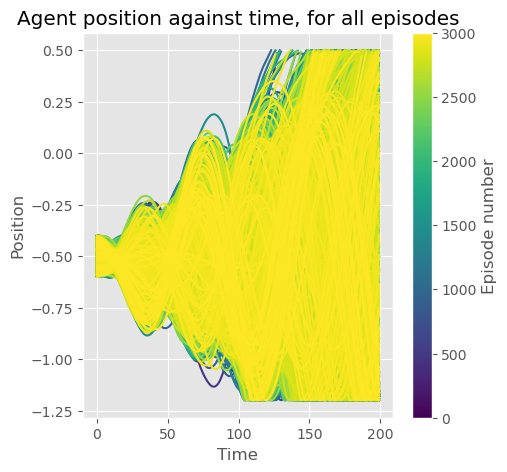

In [231]:
# Dyna agent 
DYNA_agent = DynaAgent(env=env)
DYNA_agent.train_agent()
environment_reward_tr1_dyna = DYNA_agent.data['episode_reward']
DYNA_agent.test(episodes_test=1000, seeds=seeds)
environment_reward_te1_dyna = DYNA_agent.environment_reward

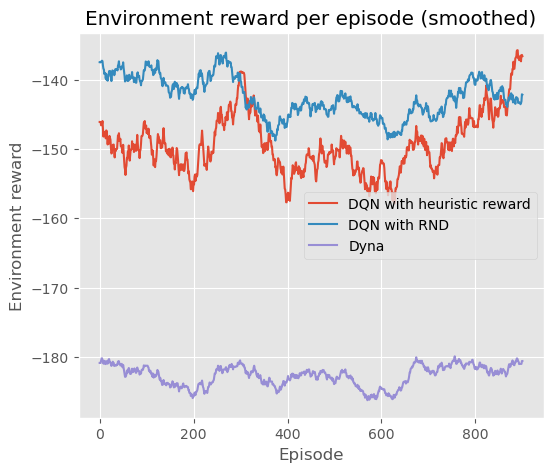

In [235]:
# plot of environment reward DQN RND
smoothed_environment_reward1 = np.convolve(environment_reward_testing1, np.ones(100)/100, mode='valid')
smoothed_environment_reward2 = np.convolve(environment_reward_te1_rnd, np.ones(100)/100, mode='valid')
smoothed_environment_reward3 = np.convolve(environment_reward_te1_dyna, np.ones(100)/100, mode='valid')

plt.figure(figsize=(6, 5))
plt.plot(smoothed_environment_reward1, label='DQN with heuristic reward')
plt.plot(smoothed_environment_reward2, label='DQN with RND')
plt.plot(smoothed_environment_reward3, label='Dyna')
plt.title('Environment reward per episode (smoothed)')
plt.xlabel('Episode')
plt.ylabel('Environment reward')
plt.legend()
plt.grid(visible=True)

In [ ]:
from scipy.spatial import ConvexHull
import matplotlib.style as style
from matplotlib.colors import Normalize

# Plots for Dyna

## Bin sizes

This parts take a lot of time to run as we train the model multiple times.
In the celle below, we define the default step. We will then test the model for steps 2 times smaller and 2, 4 and 8 times bigger

In [ ]:
discr_step=[0.025, 0.005]

### Small (*0.5)

We here see that the model take a really long time to run. As an indication, it took more than 1 hour (64 minutes) to run on a laptop with an i5-8265U CPU and 8GB of RAM.

With small bin sizes, our model succedes with a probability of :  1.0


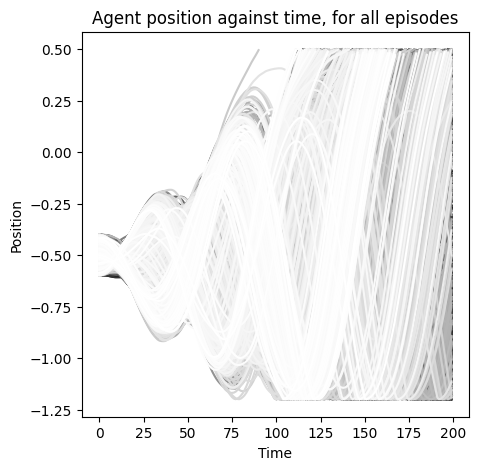

In [ ]:
proba = DynaAgent(k = 20, num_episodes= 3000, discr_step=[i/2 for i in discr_step])
proba.train_agent()
seeds = np.random.randint(0, 2**32 - 1, 50)
print("With small bin sizes, our model succedes with a probability of : ", proba.test(episodes_test=50, seeds=seeds))

### Default

We chose the default parameters as a trade-off between precision and compute time. Here, the compute time is divided by 3 (23 minutes).

With normal bin sizes, our model succedes with a probability of :  0.42


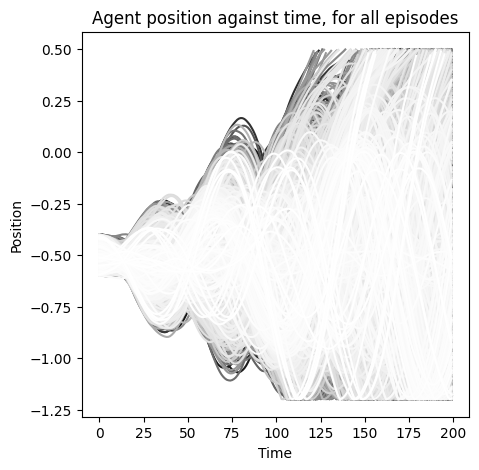

In [ ]:
proba = DynaAgent(k = 20, num_episodes= 3000)
proba.train_agent()
print("With normal bin sizes, our model succedes with a probability of : ", proba.test(episodes_test=50, seeds=seeds))

### Big (*2)

100%|██████████| 3000/3000 [21:30<00:00,  2.32it/s]


With large (*2) bin sizes, our model succedes with a probability of :  0.18


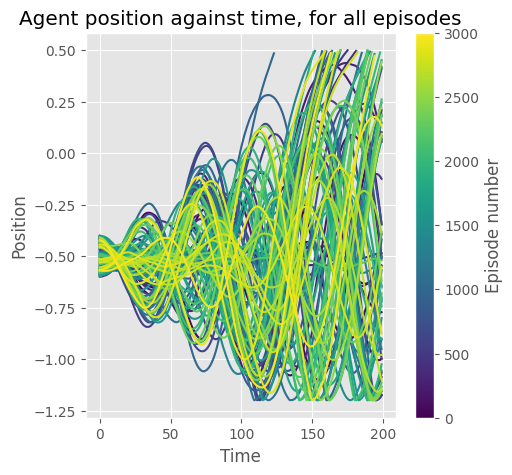

In [ ]:
proba = DynaAgent(k = 20, num_episodes= 3000, discr_step=discr_step*2)
proba.train_agent()
print("With large (*2) bin sizes, our model succedes with a probability of : ", proba.test(episodes_test=50, seeds=seeds))

### Big (*4)

In [ ]:
proba = DynaAgent(k = 20, num_episodes= 3000, discr_step=discr_step*4)
proba.train_agent()
print("With large (*4) bin sizes, our model succedes with a probability of : ", proba.test(episodes_test=50, seeds=seeds))

### Big (*8)

In [ ]:
proba = DynaAgent(k = 20, num_episodes= 3000, discr_step=discr_step*8)
proba.train_agent()
print("With large (*8) bin sizes, our model succedes with a probability of : ", proba.test(episodes_test=50, seeds=seeds))

When increasing the bin size, the perfomance after 3000 episodes decrease drastically. On the other hand, the model gets faster. 

## Model training for other analysis
For analysis other than bin size, we do not need to re-train the model every-time. Here we train it once and for all.

100%|██████████| 3000/3000 [25:12<00:00,  1.98it/s]


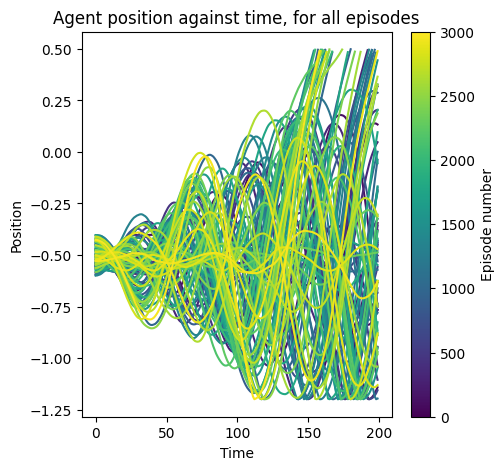

In [ ]:
proba = DynaAgent(k = 20, num_episodes= 3000)
proba.train_agent()

In [ ]:
data = proba.data
duration = data['duration']
reward = data['episode_reward']
success = data['success']
Q = proba.Q
update_steps = data['update_steps']
Q0, Q1, Q2, Q3 = data['record_Q']
positions = data['trajectories']

## Duration, reward and success

### Episode duration
#### Plot of episode duration

Text(0, 0.5, 'Duration')

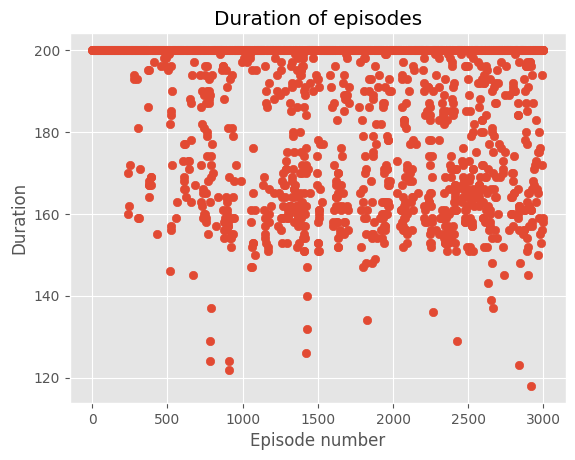

In [ ]:
plt.scatter(list(range(len(duration))), duration)
plt.title("Duration of episodes")
plt.xlabel("Episode number")
plt.ylabel("Duration")

#### Pattern in episode duration

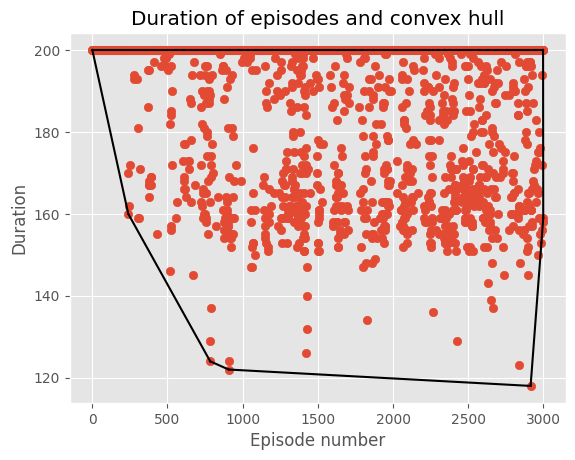

In [ ]:
# Convert duration to a 2D array with indices
points = np.column_stack((np.arange(len(duration)), duration))

# Compute Convex Hull
hull = ConvexHull(points)

# Scatter plot
plt.scatter(points[:,0], points[:,1])
plt.title("Duration of episodes and convex hull")
plt.xlabel("Episode number")
plt.ylabel("Duration")

# Draw Convex Hull
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

plt.show()

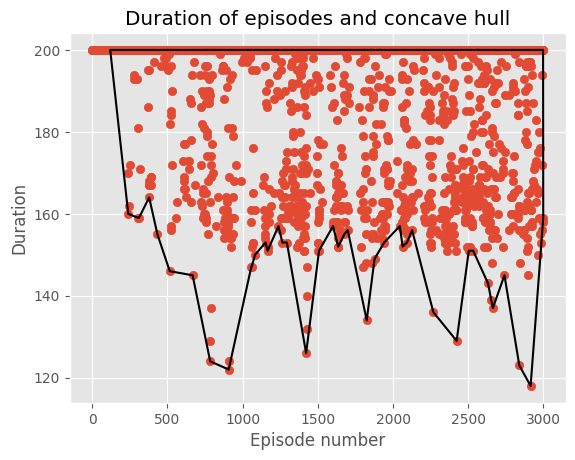

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from alphashape import alphashape
from shapely.geometry import Polygon

# Convert duration to a 2D array with indices
points = np.column_stack((np.arange(len(duration)), duration))

# Compute Concave Hull
alpha = 0.005  # Tune this parameter to include/exclude outliers
hull = alphashape(points, alpha)

# Scatter plot
plt.scatter(points[:,0], points[:,1])
plt.title("Duration of episodes and concave hull")
plt.xlabel("Episode number")
plt.ylabel("Duration")

# Draw Concave Hull
if isinstance(hull, Polygon):
    plt.plot(*hull.exterior.xy, 'k-')
elif hasattr(hull, 'geoms'):
    for geom in hull.geoms:
        plt.plot(*geom.exterior.xy, 'k-')

plt.show()

#### Window-averaged episode duration

Text(0, 0.5, 'Duration')

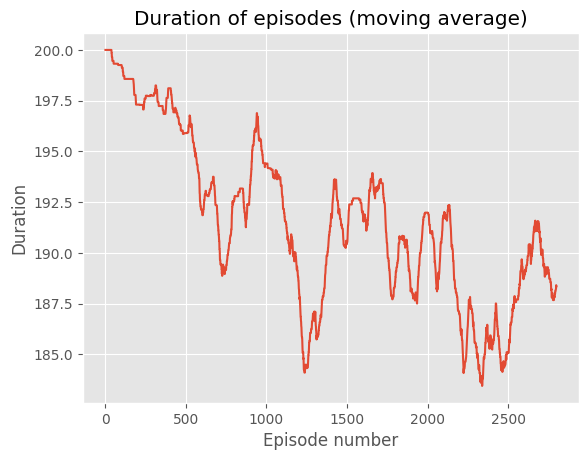

In [ ]:
window = 200
avg_duration = np.convolve(duration, np.ones(window)/window, mode='valid')
plt.plot(avg_duration)
plt.title("Duration of episodes (moving average)")
plt.xlabel("Episode number")
plt.ylabel("Duration")

### Episode reward

Text(0, 0.5, 'Reward')

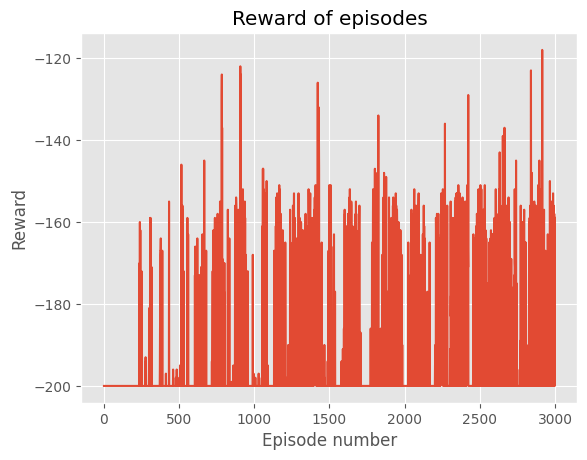

In [ ]:
plt.plot(reward)
plt.title("Reward of episodes")
plt.xlabel("Episode number")
plt.ylabel("Reward")

### Cumulative episode reward

Text(0, 0.5, 'Cumulative reward')

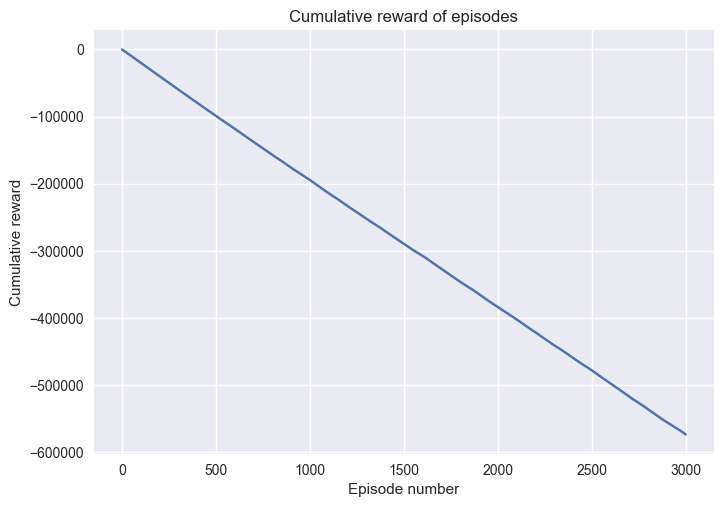

In [ ]:
cumulative_reward = np.cumsum(reward)
plt.plot(cumulative_reward)
plt.title("Cumulative reward of episodes")
plt.xlabel("Episode number")
plt.ylabel("Cumulative reward")

### Cumulative episode success

Text(0, 0.5, 'Cumulative success')

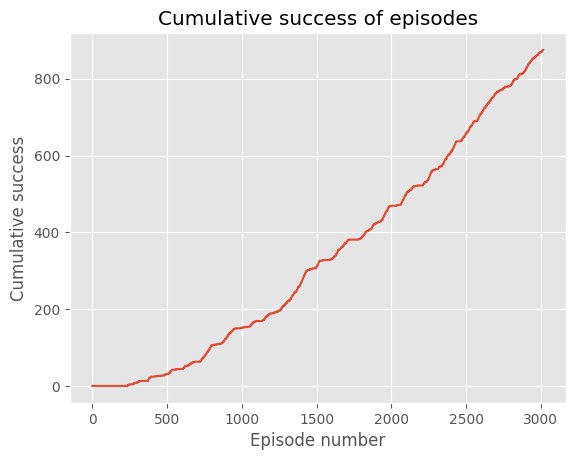

In [ ]:
cumulative_success = np.cumsum(success)
plt.plot(cumulative_success)
plt.title("Cumulative success of episodes")
plt.xlabel("Episode number")
plt.ylabel("Cumulative success")

## Q-Values

### Q-Values after learning

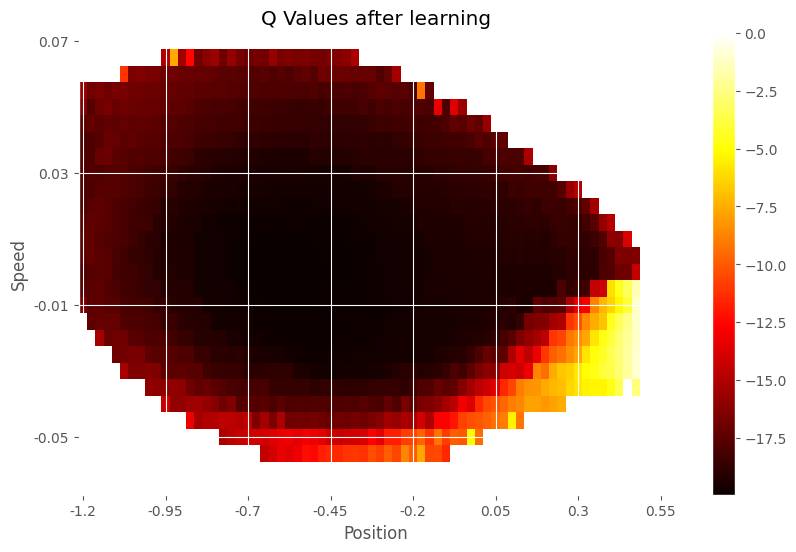

In [ ]:
discr_coord = proba.discr_coord
discr_speed = proba.discr_speed
Q_max = np.max(Q, axis=1)

Q_max_grid = Q_max.reshape((len(discr_coord)-1, len(discr_speed)-1)).transpose()
plt.figure(figsize=(10, 6))
plt.title("Q Values after learning")

# Set the x-axis ticks and labels
yt = range(0, len(discr_speed)-1, 8)
plt.yticks(yt, [round(discr_speed[::-1][y], 2) for y in yt])
plt.ylabel('Speed')

# Set the y-axis ticks and labels
xt = range(0, len(discr_coord)-1, 10)
plt.xticks(xt, [round(discr_coord[:-1][x], 2) for x in xt])
plt.xlabel('Position')

plt.imshow(Q_max_grid, cmap='hot', aspect = 2)
plt.colorbar()
plt.show()

### Q-Values update steps

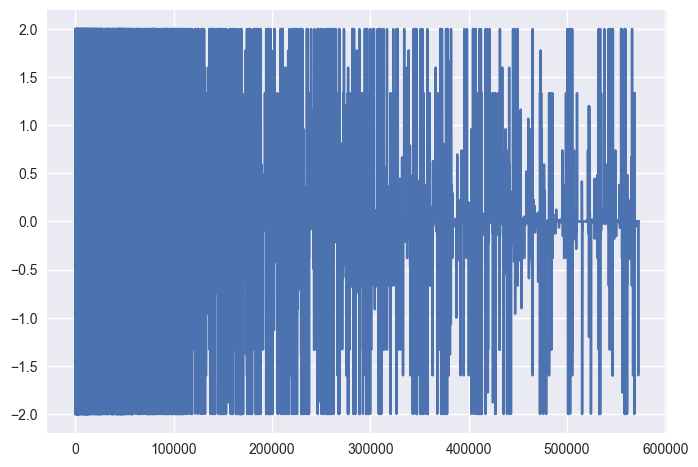

In [ ]:
plt.plot(update_steps)

### Learning the Q-Values

We plot the Q-Values on different moments of the learning

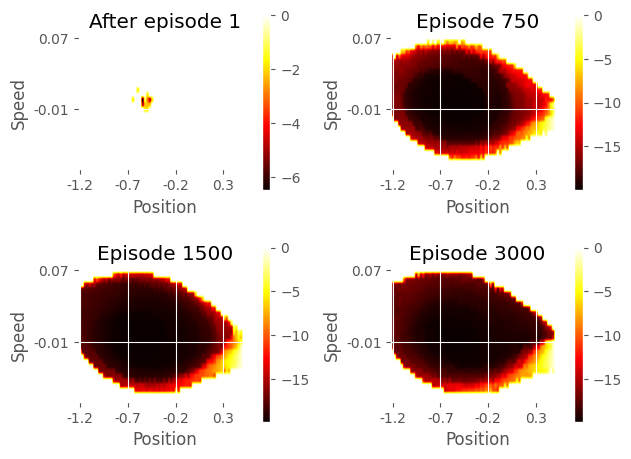

In [ ]:
discr_coord = proba.discr_coord
discr_speed = proba.discr_speed

Q0_max = np.max(Q0, axis=1)
Q1_max = np.max(Q1, axis=1)
Q2_max = np.max(Q2, axis=1)
Q3_max = np.max(Q3, axis=1)

Q0_max_grid = Q0_max.reshape((len(discr_coord)-1, len(discr_speed)-1)).transpose()
Q1_max_grid = Q1_max.reshape((len(discr_coord)-1, len(discr_speed)-1)).transpose()
Q2_max_grid = Q2_max.reshape((len(discr_coord)-1, len(discr_speed)-1)).transpose()
Q3_max_grid = Q3_max.reshape((len(discr_coord)-1, len(discr_speed)-1)).transpose()


# Set the x-axis ticks and labels
yt = range(0, len(discr_speed)-1, 15)
yl = [round(discr_speed[::-1][y], 2) for y in yt]

# Set the y-axis ticks and labels
xt = range(0, len(discr_coord)-1, 20)
xl = [round(discr_coord[:-1][x], 2) for x in xt]


fig, axs = plt.subplots(2, 2)

# Plot in the first subplot
axs[0, 0].imshow(Q0_max_grid, cmap='hot', aspect = 2)
axs[0, 0].set_title('After episode 1')
axs[0, 0].set_xlabel('Position')
axs[0, 0].set_ylabel('Speed')
axs[0, 0].set_xticks(xt, xl)
axs[0, 0].set_yticks(yt, yl)


# Plot in the second subplot
axs[0, 1].imshow(Q1_max_grid, cmap='hot', aspect = 2)
axs[0, 1].set_title('Episode 750')
axs[0, 1].set_xlabel('Position')
axs[0, 1].set_ylabel('Speed')
axs[0, 1].set_xticks(xt, xl)
axs[0, 1].set_yticks(yt, yl)

# Plot in the third subplot
axs[1, 0].imshow(Q2_max_grid, cmap='hot', aspect = 2)
axs[1, 0].set_title('Episode 1500')
axs[1, 0].set_xlabel('Position')
axs[1, 0].set_ylabel('Speed')
axs[1, 0].set_xticks(xt, xl)
axs[1, 0].set_yticks(yt, yl)

# Plot in the fourth subplot
axs[1, 1].imshow(Q_max_grid, cmap='hot', aspect = 2)
axs[1, 1].set_title('Episode 3000')
axs[1, 1].set_xlabel('Position')
axs[1, 1].set_ylabel('Speed')
axs[1, 1].set_xticks(xt, xl)
axs[1, 1].set_yticks(yt, yl)


fig.colorbar(axs[0, 0].imshow(Q0_max_grid, cmap='hot', aspect = 2))
fig.colorbar(axs[0, 1].imshow(Q1_max_grid, cmap='hot', aspect = 2))
fig.colorbar(axs[1, 0].imshow(Q2_max_grid, cmap='hot', aspect = 2))
fig.colorbar(axs[1, 1].imshow(Q_max_grid, cmap='hot', aspect = 2))
plt.tight_layout()
plt.show()

## Trajectories
We plot important trajectories, on top of the Q-Values

In [ ]:
discretize = proba.discretize_state_func

def traj_from_pos(pos):
    x = []
    y = []
    for state in pos:
        x.append(int((np.array(state)[0][0] - proba.env.observation_space.low[0]) / proba.discr_step[0]))
        y.append(int((np.array(state)[0][1] - proba.env.observation_space.low[1]) / proba.discr_step[1]))
    return x, y

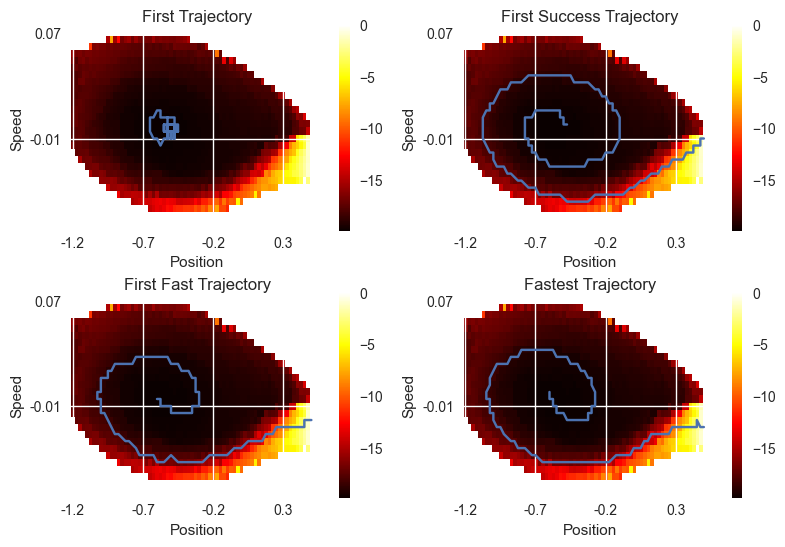

In [ ]:
duration_success = [x if success[i] == 1 else 200 for i, x in enumerate(duration)]

first = 0
first_success = min([i for i, x in enumerate(duration_success) if x <200])
first_fast = min([i for i, x in enumerate(duration_success) if x <140])
fastest = duration.index(min(duration_success))

discr_coord = proba.discr_coord
discr_speed = proba.discr_speed

# Set the x-axis ticks and labels
yt = range(0, len(discr_speed)-1, 15)
yl = [round(discr_speed[::-1][y], 2) for y in yt]

# Set the y-axis ticks and labels
xt = range(0, len(discr_coord)-1, 20)
xl = [round(discr_coord[:-1][x], 2) for x in xt]


fig, axs = plt.subplots(2, 2)

# Plot in the first subplot
x, y = traj_from_pos(positions[first])
axs[0, 0].imshow(Q_max_grid, cmap='hot', aspect = 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('First Trajectory')
axs[0, 0].set_xlabel('Position')
axs[0, 0].set_ylabel('Speed')
axs[0, 0].set_xticks(xt, xl)
axs[0, 0].set_yticks(yt, yl)


# Plot in the second subplot
x, y = traj_from_pos(positions[first_success])

axs[0, 1].imshow(Q_max_grid, cmap='hot', aspect = 2)
axs[0, 1].plot(x, y)
axs[0, 1].set_title('First Success Trajectory')
axs[0, 1].set_xlabel('Position')
axs[0, 1].set_ylabel('Speed')
axs[0, 1].set_xticks(xt, xl)
axs[0, 1].set_yticks(yt, yl)

# Plot in the third subplot
x, y = traj_from_pos(positions[first_fast])
axs[1, 0].plot(x, y)
axs[1, 0].imshow(Q_max_grid, cmap='hot', aspect = 2)
axs[1, 0].set_title('First Fast Trajectory')
axs[1, 0].set_xlabel('Position')
axs[1, 0].set_ylabel('Speed')
axs[1, 0].set_xticks(xt, xl)
axs[1, 0].set_yticks(yt, yl)

# Plot in the fourth subplot
x, y = traj_from_pos(positions[fastest])
axs[1, 1].plot(x, y)
axs[1, 1].imshow(Q_max_grid, cmap='hot', aspect = 2)
axs[1, 1].set_title('Fastest Trajectory')
axs[1, 1].set_xlabel('Position')
axs[1, 1].set_ylabel('Speed')
axs[1, 1].set_xticks(xt, xl)
axs[1, 1].set_yticks(yt, yl)

fig.colorbar(axs[0, 0].imshow(Q_max_grid, cmap='hot', aspect = 2))
fig.colorbar(axs[0, 1].imshow(Q_max_grid, cmap='hot', aspect = 2))
fig.colorbar(axs[1, 0].imshow(Q_max_grid, cmap='hot', aspect = 2))
fig.colorbar(axs[1, 1].imshow(Q_max_grid, cmap='hot', aspect = 2))
plt.tight_layout()
plt.show()

Notes

The Dyna Agent manages to solve the task. It is based on a non-deterministic model (and the environment itslef is also non-deterministic) so for some discretization step-size and number of training episodes it succedes not everytime but fairly often. For small steps (see after) and 3000 episodes, it succedes every time.

Using overly small step size makes the training really computationnaly heavy, when too large steps make it underperform as Q Values are not well learned. We used different bin size, but ultimately we settled for the default step size for time-reason (25 min for 3000 episodes).

We see that alongside training, Q-Values update are more and more sparse, but always symetric to zero. This means that our model oscillates around the true Q values.

When it comes to episode duration, we see that our model reaches is best performance around 1500 episodes, and then gets slightly worse. This is due to the fact that the model will favour more sound strategies that work everytime but are not the fastest.